# NYC FHVHV Trip Data 2024 - EDA
### Course: NYU – Data Science (Final Project)
### Focus of this notebook: EDA
### Author: Desmond Peng, Harvey Yang
---
## Analysis Workflow

1. **Dataset Overview** 
2. **Data Quality Assessment** 
3. **Data Cleaning** 
4. **Summary Statistics**  
5. **EDA** 
---

## Libraries and Environment Settings

In [1]:
# import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import json
import warnings
from glob import glob
import gc
from IPython.display import display

# ignore warnings
warnings.filterwarnings('ignore')

# Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

# Matplotlib settings
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.edgecolor'] = 'none'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.titlecolor'] = 'black'

## Analysis Functions

Define analysis functions that will be used throughout the notebook.

In [2]:
def get_file_statistics():
    """
    Get basic statistics about all parquet files in the current directory.
    
    Scans the current directory for FHVHV trip data parquet files and calculates
    total file count and total size.
    
    Returns:
    --------
    list
        List of Path objects for all found parquet files
        
    Examples:
    --------
    >>> files = get_file_statistics()
    Dataset: 12 files, 5.40 GB total
    """
    data_dir = Path(".")
    parquet_files = sorted(list(data_dir.glob("fhvhv_tripdata_2024-*.parquet")))
    parquet_files = [f for f in parquet_files if f.name != "fhvhv_tripdata_2024.parquet"]
    
    total_size = sum(file.stat().st_size / (1024**3) for file in parquet_files)
    print(f"Dataset: {len(parquet_files)} files, {total_size:.6f} GB total")
    return parquet_files


def analyze_dataset_structure(df):
    """
    Display basic dataset structure and schema information.
    
    Shows the number of rows and columns in the dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to analyze
    
    Returns:
    --------
    pandas.DataFrame
        The input DataFrame (unchanged)
    
    Examples:
    --------
    >>> analyze_dataset_structure(df)
    Dataset: 43,680,321 rows × 11 columns
    """
    print(f"Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
    return df


# ============================================================================
# ============================================================================
# Data Quality Analysis Functions
def analyze_data_quality(df):
    """
    Comprehensive data quality assessment with detailed reporting.
    
    Analyzes the dataset for various data quality issues including:
    - Missing values (null/NaN) - detailed by column
    - Duplicate records
    - Invalid values (negative fares, negative distances, negative times)
    - Data consistency issues (dropoff before pickup)
    - Zero values in critical fields
    - Extreme outliers
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing trip data
    
    Returns:
    --------
    pandas.DataFrame
        The input DataFrame (unchanged)
    
    Examples:
    --------
    >>> analyze_data_quality(df)
    Missing: 0 (100.00%)
    Duplicates: 0 (0.00%)
    Issues: Negative fares
    """
    total_rows = len(df)
    total_cols = len(df.columns)
    
    print(f"\nDataset Overview:")
    print(f"  Total records: {total_rows:,}")
    print(f"  Total columns: {total_cols}")
    
    # ===== 1. Missing Values Analysis =====
    print(f"\n[1] Missing Values Analysis")
    print("-" * 80)
    missing = df.isnull().sum()
    missing_pct = (missing / total_rows * 100).round(2)
    completeness = ((total_rows * total_cols - missing.sum()) / (total_rows * total_cols) * 100)
    
    if missing.sum() > 0:
        print(f"  Total missing values: {missing.sum():,} ({100-completeness:.6f}% of all cells)")
        print(f"  Columns with missing values:")
        for col in missing[missing > 0].index:
            print(f"    - {col}: {missing[col]:,} ({missing_pct[col]:.6f}%)")
    else:
        print(f"  [OK] No missing values found (100% completeness)")
    
    # ===== 2. Duplicate Records Analysis =====
    print(f"\n[2] Duplicate Records Analysis")
    print("-" * 80)
    full_duplicates = df.duplicated().sum()
    if full_duplicates > 0:
        print(f"  Total duplicate rows: {full_duplicates:,} ({full_duplicates/total_rows*100:.6f}%)")
        # Show sample duplicates
        dup_sample = df[df.duplicated()].head(3)
        if len(dup_sample) > 0:
            print(f"  Sample duplicate records:")
            display(dup_sample)
    else:
        print(f"  [OK] No duplicate rows found")
    
    # ===== 3. Negative Values Analysis =====
    print(f"\n[3] Negative Values Analysis")
    print("-" * 80)
    negative_issues = []
    
    # Check fare columns
    fare_cols = ['base_passenger_fare', 'tips', 'tolls', 'airport_fee', 'driver_pay']
    for col in fare_cols:
        if col in df.columns:
            negative_count = (df[col] < 0).sum()
            if negative_count > 0:
                negative_pct = (negative_count / total_rows * 100)
                min_val = df[col].min()
                print(f"  {col}: {negative_count:,} negative values ({negative_pct:.6f}%)")
                print(f"    Min value: ${min_val:.6f}")
                negative_issues.append(f"{col}: {negative_count:,}")
    
    # Check trip_miles
    if 'trip_miles' in df.columns:
        negative_miles = (df['trip_miles'] < 0).sum()
        if negative_miles > 0:
            negative_pct = (negative_miles / total_rows * 100)
            min_val = df['trip_miles'].min()
            print(f"  trip_miles: {negative_miles:,} negative values ({negative_pct:.6f}%)")
            print(f"    Min value: {min_val:.6f} miles")
            negative_issues.append(f"trip_miles: {negative_miles:,}")
    
    # Check trip_time
    if 'trip_time' in df.columns:
        negative_time = (df['trip_time'] < 0).sum()
        if negative_time > 0:
            negative_pct = (negative_time / total_rows * 100)
            min_val = df['trip_time'].min()
            print(f"  trip_time: {negative_time:,} negative values ({negative_pct:.6f}%)")
            print(f"    Min value: {min_val} seconds")
            negative_issues.append(f"trip_time: {negative_time:,}")
    
    if not negative_issues:
        print(f"  [OK] No negative values found")
    
    # ===== 4. Zero Values Analysis =====
    print(f"\n[4] Zero Values Analysis (Potential Issues)")
    print("-" * 80)
    zero_issues = []
    
    if 'trip_miles' in df.columns:
        zero_miles = (df['trip_miles'] == 0).sum()
        if zero_miles > 0:
            zero_pct = (zero_miles / total_rows * 100)
            print(f"  trip_miles: {zero_miles:,} zero values ({zero_pct:.6f}%)")
            zero_issues.append(f"trip_miles: {zero_miles:,}")
    
    if 'trip_time' in df.columns:
        zero_time = (df['trip_time'] == 0).sum()
        if zero_time > 0:
            zero_pct = (zero_time / total_rows * 100)
            print(f"  trip_time: {zero_time:,} zero values ({zero_pct:.6f}%)")
            zero_issues.append(f"trip_time: {zero_time:,}")
    
    if 'base_passenger_fare' in df.columns:
        zero_fare = (df['base_passenger_fare'] == 0).sum()
        if zero_fare > 0:
            zero_pct = (zero_fare / total_rows * 100)
            print(f"  base_passenger_fare: {zero_fare:,} zero values ({zero_pct:.6f}%)")
            zero_issues.append(f"base_passenger_fare: {zero_fare:,}")
    
    if not zero_issues:
        print(f"  [OK] No suspicious zero values found")
    
    # ===== 5. Time Consistency Analysis =====
    print(f"\n[5] Time Consistency Analysis")
    print("-" * 80)
    if 'pickup_datetime' in df.columns and 'dropoff_datetime' in df.columns:
        if df['pickup_datetime'].dtype == 'datetime64[ns]' and df['dropoff_datetime'].dtype == 'datetime64[ns]':
            invalid_order = (df['dropoff_datetime'] < df['pickup_datetime']).sum()
            if invalid_order > 0:
                invalid_pct = (invalid_order / total_rows * 100)
                print(f"  Invalid time order: {invalid_order:,} trips ({invalid_pct:.6f}%)")
                print(f"    (dropoff_datetime < pickup_datetime)")
                
                # Show sample invalid records
                invalid_sample = df[df['dropoff_datetime'] < df['pickup_datetime']].head(3)
                if len(invalid_sample) > 0:
                    print(f"  Sample invalid records:")
                    display(invalid_sample[['pickup_datetime', 'dropoff_datetime']])
            else:
                print(f"  [OK] All trips have valid time order")
        else:
            print(f"  [WARN] Datetime columns not properly converted")
    else:
        print(f"  [WARN] Datetime columns not found")
    
    # ===== 6. Extreme Outliers Analysis =====
    print(f"\n[6] Extreme Outliers Analysis")
    print("-" * 80)
    outlier_issues = []
    
    if 'trip_miles' in df.columns:
        # Trips longer than 100 miles (likely errors)
        extreme_miles = (df['trip_miles'] > 100).sum()
        if extreme_miles > 0:
            extreme_pct = (extreme_miles / total_rows * 100)
            max_miles = df['trip_miles'].max()
            print(f"  trip_miles > 100 miles: {extreme_miles:,} trips ({extreme_pct:.6f}%)")
            print(f"    Max value: {max_miles:.6f} miles")
            outlier_issues.append(f"trip_miles > 100: {extreme_miles:,}")
    
    if 'trip_time' in df.columns:
        # Trips longer than 24 hours (likely errors)
        extreme_time = (df['trip_time'] > 24 * 3600).sum()
        if extreme_time > 0:
            extreme_pct = (extreme_time / total_rows * 100)
            max_time = df['trip_time'].max()
            max_hours = max_time / 3600
            print(f"  trip_time > 24 hours: {extreme_time:,} trips ({extreme_pct:.6f}%)")
            print(f"    Max value: {max_hours:.6f} hours ({max_time:,} seconds)")
            outlier_issues.append(f"trip_time > 24h: {extreme_time:,}")
    
    if 'base_passenger_fare' in df.columns:
        # Extremely high fares (likely errors)
        extreme_fare = (df['base_passenger_fare'] > 1000).sum()
        if extreme_fare > 0:
            extreme_pct = (extreme_fare / total_rows * 100)
            max_fare = df['base_passenger_fare'].max()
            print(f"  base_passenger_fare > $1000: {extreme_fare:,} trips ({extreme_pct:.6f}%)")
            print(f"    Max value: ${max_fare:.6f}")
            outlier_issues.append(f"base_passenger_fare > $1000: {extreme_fare:,}")
    
    if not outlier_issues:
        print(f"  [OK] No extreme outliers detected")
    
    # Note: Summary will be generated after all checks are complete in the main cell
    # Return df for consistency
    return df


def analyze_numeric_fields(df):
    """
    Analyze numeric fields in the dataset.
    
    Identifies numeric columns (excluding location IDs and trip_time) and
    displays summary statistics (mean and median) for all fields.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to analyze
    
    Returns:
    --------
    pandas.DataFrame
        The input DataFrame (unchanged)
    
    Examples:
    --------
    >>> analyze_numeric_fields(df)
    Numeric fields (8):
      trip_miles: mean=5.08, median=3.02
      base_passenger_fare: mean=26.06, median=19.53
      ...
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['PULocationID', 'DOLocationID', 'trip_time']]
    
    print(f"\nNumeric fields ({len(numeric_cols)}):")
    for col in numeric_cols:
        mean_val = df[col].mean()
        median_val = df[col].median()
        print(f"  {col}: mean={mean_val:.6f}, median={median_val:.6f}")
    return df


def analyze_categorical_fields(df):
    """
    Analyze categorical fields in the dataset.
    
    Identifies categorical/object type columns (excluding datetime-like columns)
    and displays the count of categorical fields.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to analyze
    
    Returns:
    --------
    None
        Prints the number of categorical fields
    
    Examples:
    --------
    >>> analyze_categorical_fields(df)
    Categorical fields: 1
    """
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    datetime_like = ['request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime']
    categorical_cols = [col for col in categorical_cols if col not in datetime_like]
    if categorical_cols:
        print(f"Categorical fields: {len(categorical_cols)}")
    else:
        print("No categorical fields")


def analyze_temporal_data(df):
    """
    Analyze temporal aspects of the dataset.
    
    Displays date range and trip duration statistics.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing trip data with pickup_datetime and trip_time columns
        
    Returns:
    --------
    None
        Prints temporal analysis results
        
    Examples:
    --------
    >>> analyze_temporal_data(df)
    Date range: 2024-01-01 to 2024-11-30 (334 days)
    Trip duration: mean=20.1 min, median=16.3 min
    """
    if 'pickup_datetime' in df.columns:
        span_days = (df['pickup_datetime'].max() - df['pickup_datetime'].min()).days
        print(f"Date range: {df['pickup_datetime'].min().date()} to {df['pickup_datetime'].max().date()} ({span_days} days)")
    if 'trip_time' in df.columns:
        print(f"Trip duration: mean={df['trip_time'].mean()/60:.6f} min, median={df['trip_time'].median()/60:.6f} min")


def analyze_trip_characteristics(df):
    """
    Analyze trip characteristics including distance, fare, and location information.
    
    Calculates and displays summary statistics for:
    - Average trip distance
    - Average total fare (sum of all fare components)
    - Number of unique pickup and dropoff zones
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing trip data
    
    Returns:
    --------
    None
        Prints trip characteristics summary
    
    Examples:
    --------
    >>> analyze_trip_characteristics(df)
    Distance: 5.08 mi (mean) | Fare: $48.47 (avg) | Zones: 262 pickup, 263 dropoff
    """
    results = []
    if 'trip_miles' in df.columns:
        results.append(f"Distance: {df['trip_miles'].mean():.6f} mi (mean)")
    
    fare_cols = ['base_passenger_fare', 'tips', 'tolls', 'driver_pay']
    fare_total = sum(df[col].mean() for col in fare_cols if col in df.columns)
    if fare_total > 0:
        results.append(f"Fare: ${fare_total:.6f} (avg)")
    
    if 'PULocationID' in df.columns:
        results.append(f"Zones: {df['PULocationID'].nunique()} pickup, {df['DOLocationID'].nunique()} dropoff")
    
    print("\n" + " | ".join(results))


def sample_data_display(df):
    """
    Display a sample of all columns from the dataset.
    
    Shows the first 5 rows of all columns in the dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to display
    
    Returns:
    --------
    None
        Displays a sample DataFrame using IPython.display
    
    Examples:
    --------
    >>> sample_data_display(df)
    Sample (11 columns):
    [Displays first 5 rows of all columns]
    """
    print(f"\nSample ({len(df.columns)} columns):")
    display(df.head(5))


## Visualization Functions

Define visualization functions that will be used throughout the notebook.

In [3]:
# ============================================================================
# Visualization Functions
# ============================================================================

def create_distribution_plots(df, output_dir="plots"):
    """
    Create distribution plots for key trip metrics.
    
    Generates histograms for:
    - Trip distance (miles)
    - Trip duration (minutes)
    - Base passenger fare (dollars)
    
    Each plot includes mean and median reference lines and uses the 99th
    percentile to focus on the main data distribution.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing trip data with columns: trip_miles, trip_time,
        base_passenger_fare
    output_dir : str, default="plots"
        Directory to save output plots
        
    Returns:
    --------
    None
        Saves plots to output directory
    """
    Path(output_dir).mkdir(exist_ok=True)
    
    print("\nCreating distribution plots...")
    
    # Trip distance distribution
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    distance_data = df['trip_miles']
    
    # Use 99th percentile for better range (shows most data clearly)
    upper_limit = distance_data.quantile(0.99)
    
    # Use ALL data (don't filter, just adjust display range)
    # Specify bins explicitly to ensure correct binning
    num_bins = 50
    bin_edges = np.linspace(0, upper_limit, num_bins + 1)
    ax.hist(distance_data, bins=bin_edges, edgecolor='black', alpha=0.7, 
            color='steelblue', linewidth=0.5)
    ax.set_xlabel('Trip Distance (miles)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Trip Distances', fontsize=14, fontweight='bold', pad=15)
    ax.axvline(distance_data.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {distance_data.mean():.2f} miles')
    ax.axvline(distance_data.median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {distance_data.median():.2f} miles')
    ax.set_xlim(left=0, right=upper_limit)
    ax.legend(loc='upper right', framealpha=0.9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/trip_distance_distribution.png', dpi=150, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    print("  [OK] Saved: trip_distance_distribution.png")
    
    # Trip duration distribution
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    duration_data = df['trip_time'] / 60  # Convert to minutes
    
    # Use 99th percentile for better range
    upper_limit = duration_data.quantile(0.99)
    
    # Use ALL data (don't filter, just adjust display range)
    # Specify bins explicitly to ensure correct binning
    num_bins = 50
    bin_edges = np.linspace(0, upper_limit, num_bins + 1)
    ax.hist(duration_data, bins=bin_edges, edgecolor='black', alpha=0.7,
            color='steelblue', linewidth=0.5)
    ax.set_xlabel('Trip Duration (minutes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Trip Durations', fontsize=14, fontweight='bold', pad=15)
    ax.axvline(duration_data.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {duration_data.mean():.2f} min')
    ax.axvline(duration_data.median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {duration_data.median():.2f} min')
    ax.set_xlim(left=0, right=upper_limit)
    ax.legend(loc='upper right', framealpha=0.9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/trip_duration_distribution.png', dpi=150, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    print("  [OK] Saved: trip_duration_distribution.png")
    
    # Fare distribution
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    fare_data = df['base_passenger_fare']
    
    # Use 99th percentile for better range
    upper_limit = fare_data.quantile(0.99)
    
    # Use ALL data (don't filter, just adjust display range)
    # Specify bins explicitly to ensure correct binning
    num_bins = 50
    bin_edges = np.linspace(0, upper_limit, num_bins + 1)
    ax.hist(fare_data, bins=bin_edges, edgecolor='black', alpha=0.7,
            color='steelblue', linewidth=0.5)
    ax.set_xlabel('Base Passenger Fare ($)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Base Passenger Fares', fontsize=14, fontweight='bold', pad=15)
    ax.axvline(fare_data.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: ${fare_data.mean():.2f}')
    ax.axvline(fare_data.median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: ${fare_data.median():.2f}')
    ax.set_xlim(left=0, right=upper_limit)
    ax.legend(loc='upper right', framealpha=0.9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/fare_distribution.png', dpi=150, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    print("  [OK] Saved: fare_distribution.png")

def create_temporal_analysis(df, output_dir="plots"):
    """
    Create temporal analysis visualizations.
    
    Generates plots showing:
    - Hourly trip distribution (24-hour pattern)
    - Weekly trip distribution (day of week pattern)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing trip data with pickup_datetime column
    output_dir : str, default="plots"
        Directory to save output plots
        
    Returns:
    --------
    None
        Saves plots to output directory
    """
    print("\nCreating temporal analysis...")
    
    # Extract hour from pickup datetime
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    hourly_counts = df['pickup_hour'].value_counts().sort_index()
    
    fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
    bars = ax.bar(hourly_counts.index, hourly_counts.values, alpha=0.7, 
                  edgecolor='black', color='steelblue', linewidth=0.5, label='All Trips')
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Trips', fontsize=12, fontweight='bold')
    ax.set_title('Trip Distribution by Hour of Day', fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(range(24))
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', framealpha=0.9, fontsize=10)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/trips_by_hour.png', dpi=150, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    print("  [OK] Saved: trips_by_hour.png")
    
    # Extract day of week
    df['day_of_week'] = df['pickup_datetime'].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts = df['day_of_week'].value_counts().reindex(day_order)
    
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    bars = ax.bar(day_counts.index, day_counts.values, alpha=0.7, 
                  edgecolor='black', color='steelblue', linewidth=0.5, label='All Trips')
    ax.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Trips', fontsize=12, fontweight='bold')
    ax.set_title('Trip Distribution by Day of Week', fontsize=14, fontweight='bold', pad=15)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', framealpha=0.9, fontsize=10)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/trips_by_day.png', dpi=150, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    print("  [OK] Saved: trips_by_day.png")

def create_location_analysis(df, output_dir="plots", zone_lookup_dict=None):
    """
    Create location-based analysis visualizations.
    
    Generates horizontal bar charts for:
    - Top 15 pickup locations by frequency
    - Top 15 dropoff locations by frequency
    
    If zone_lookup_dict is provided, displays zone names instead of IDs.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing trip data with PULocationID and DOLocationID columns
    output_dir : str, default="plots"
        Directory to save output plots
    zone_lookup_dict : dict, optional
        Dictionary mapping LocationID to zone names. If None, uses LocationID values.
        
    Returns:
    --------
    None
        Saves plots to output directory
    """
    print("\nCreating location analysis...")
    
    # Top pickup locations
    top_pickups = df['PULocationID'].value_counts().head(15)
    
    # Use zone names if lookup dictionary is provided
    if zone_lookup_dict:
        pickup_labels = [zone_lookup_dict.get(zone_id, f"Zone {zone_id}") 
                        for zone_id in top_pickups.index]
    else:
        pickup_labels = [f"Zone {zone_id}" for zone_id in top_pickups.index]
    
    fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
    bars = ax.barh(range(len(top_pickups)), top_pickups.values, alpha=0.7, 
                   edgecolor='black', color='steelblue', linewidth=0.5, label='Top 15 Pickup Zones')
    ax.set_yticks(range(len(top_pickups)))
    ax.set_yticklabels(pickup_labels, fontsize=10)
    ax.set_xlabel('Number of Pickups', fontsize=12, fontweight='bold')
    ax.set_title('Top 15 Pickup Locations (by frequency)', fontsize=14, fontweight='bold', pad=15)
    ax.invert_yaxis()
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, top_pickups.values)):
        ax.text(bar.get_width() + bar.get_width()*0.01, bar.get_y() + bar.get_height()/2,
                f'{count:.2f}', va='center', fontsize=9, fontweight='bold')
    
    ax.legend(loc='lower right', framealpha=0.9, fontsize=10)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/top_pickup_locations.png', dpi=150, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    print("  [OK] Saved: top_pickup_locations.png")
    
    # Top dropoff locations
    top_dropoffs = df['DOLocationID'].value_counts().head(15)
    
    # Use zone names if lookup dictionary is provided
    if zone_lookup_dict:
        dropoff_labels = [zone_lookup_dict.get(zone_id, f"Zone {zone_id}") 
                         for zone_id in top_dropoffs.index]
    else:
        dropoff_labels = [f"Zone {zone_id}" for zone_id in top_dropoffs.index]
    
    fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
    bars = ax.barh(range(len(top_dropoffs)), top_dropoffs.values, alpha=0.7, 
                   edgecolor='black', color='steelblue', linewidth=0.5, label='Top 15 Dropoff Zones')
    ax.set_yticks(range(len(top_dropoffs)))
    ax.set_yticklabels(dropoff_labels, fontsize=10)
    ax.set_xlabel('Number of Dropoffs', fontsize=12, fontweight='bold')
    ax.set_title('Top 15 Dropoff Locations (by frequency)', fontsize=14, fontweight='bold', pad=15)
    ax.invert_yaxis()
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, top_dropoffs.values)):
        ax.text(bar.get_width() + bar.get_width()*0.01, bar.get_y() + bar.get_height()/2,
                f'{count:.2f}', va='center', fontsize=9, fontweight='bold')
    
    ax.legend(loc='lower right', framealpha=0.9, fontsize=10)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/top_dropoff_locations.png', dpi=150, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    print("  [OK] Saved: top_dropoff_locations.png")



def create_demand_analysis(df, output_dir="plots", top_zones=20, zone_lookup_dict=None, sample_ratio=1.0):
    """
    Create comprehensive demand analysis visualizations.
    
    Generates multiple visualizations:
    - Demand heatmap (hour × zone)
    - Peak hour ranking chart
    - Temporal pattern plot (weekday vs weekend)
    - Demand volatility table with statistics
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing trip data with pickup_datetime and PULocationID columns
    output_dir : str, default="plots"
        Directory to save output plots
    top_zones : int, default=20
        Number of top zones to analyze
    zone_lookup_dict : dict, optional
        Dictionary mapping LocationID to zone names. If None, uses "Zone {ID}" format.
        
    Returns:
    --------
    None
        Saves plots and CSV to output directory
    """
    print("\nCreating demand analysis outputs...")
    Path(output_dir).mkdir(exist_ok=True)

    required_columns = ['pickup_datetime', 'PULocationID']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"  [WARN] Missing required columns for demand analysis: {missing_columns}")
        return

    demand_df = (
        df[required_columns]
        .dropna(subset=required_columns)
        .copy()
    )

    if demand_df.empty:
        print("  [WARN] No valid pickup records available for demand analysis.")
        return

    demand_df['pickup_datetime'] = pd.to_datetime(demand_df['pickup_datetime'])
    demand_df['pickup_hour'] = demand_df['pickup_datetime'].dt.hour
    demand_df['pickup_date'] = demand_df['pickup_datetime'].dt.date
    demand_df['pickup_weekday'] = demand_df['pickup_datetime'].dt.dayofweek
    demand_df['is_weekend'] = demand_df['pickup_weekday'] >= 5
    demand_df['PULocationID'] = demand_df['PULocationID'].astype(int)
    # Use zone names if lookup dictionary is provided
    if zone_lookup_dict:
        demand_df['zone_label'] = demand_df['PULocationID'].map(
            lambda x: zone_lookup_dict.get(x, f"Zone {x}")
        )
    else:
        demand_df['zone_label'] = demand_df['PULocationID'].map(lambda x: f"Zone {x}")

    zone_counts = demand_df['zone_label'].value_counts()
    if zone_counts.empty:
        print("  [WARN] Unable to compute zone frequency counts.")
        return

    zone_order = zone_counts.head(top_zones).index.tolist()
    filtered_df = demand_df[demand_df['zone_label'].isin(zone_order)]

    # ----------------------------------------------------------------------------------
    # 1. Demand Heatmap (Hour × Zone)
    # ----------------------------------------------------------------------------------
    heatmap_counts = (
        filtered_df
        .groupby(['zone_label', 'pickup_hour'])
        .size()
        .unstack(fill_value=0)
        .reindex(index=zone_order, columns=range(24), fill_value=0)
    )

    fig, ax = plt.subplots(figsize=(16, max(6, 0.4 * len(zone_order))), facecolor='white')
    im = ax.imshow(heatmap_counts.values, aspect='auto', cmap='YlOrRd')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Trip Count', fontsize=11, fontweight='bold')
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Pickup Zone', fontsize=12, fontweight='bold')
    ax.set_title(f'Demand Heatmap (Top {len(zone_order)} Zones)', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(range(24), range(24))
    ax.set_yticks(range(len(zone_order)), zone_order, fontsize=9)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # Add annotations for readability when the matrix is reasonably sized
    if len(zone_order) <= 25:
        max_val = heatmap_counts.values.max()
        threshold = max_val * 0.5 if max_val > 0 else 0
        for i, zone in enumerate(zone_order):
            for j in range(24):
                value = int(heatmap_counts.iloc[i, j])
                if value == 0:
                    continue
                text_color = 'white' if value >= threshold else 'black'
                ax.text(j, i, f'{int(value)}', ha='center', va='center',
                         color=text_color, fontsize=7, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/demand_heatmap.png', dpi=150, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    print("  [OK] Saved: demand_heatmap.png")

    # ----------------------------------------------------------------------------------
    # 2. Peak Hour Chart
    # ----------------------------------------------------------------------------------
    zone_hourly = (
        heatmap_counts
        .stack()
        .reset_index(name='trip_count')
        .rename(columns={'level_1': 'pickup_hour'})
    )

    peak_hours = (
        zone_hourly
        .sort_values('trip_count', ascending=False)
        .groupby('zone_label')
        .head(1)
        .sort_values('trip_count', ascending=False)
    )

    top_peak_hours = peak_hours.head(min(15, len(peak_hours)))

    fig, ax = plt.subplots(figsize=(12, max(6, 0.4 * len(top_peak_hours))), facecolor='white')
    bars = ax.barh(
        top_peak_hours['zone_label'],
        top_peak_hours['trip_count'],
        color='steelblue',
        edgecolor='black',
        alpha=0.85,
        linewidth=0.5,
        label='Peak Hour Volume'
    )
    ax.set_xlabel('Trips (Peak Hour Volume)', fontsize=12, fontweight='bold')
    ax.set_title('Peak Hour Ranking by Pickup Zone', fontsize=14, fontweight='bold', pad=15)
    ax.invert_yaxis()
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.legend(loc='lower right', framealpha=0.9, fontsize=10)

    for bar, hour in zip(bars, top_peak_hours['pickup_hour']):
        width = bar.get_width()
        ax.text(
            width + (width * 0.01 if width > 0 else 0.5),
            bar.get_y() + bar.get_height() / 2,
            f'{int(hour):02d}:00',
            va='center',
            fontsize=10,
            fontweight='bold'
        )

    plt.tight_layout()
    plt.savefig(f'{output_dir}/peak_hour_chart.png', dpi=150, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    print("  [OK] Saved: peak_hour_chart.png")

    # ----------------------------------------------------------------------------------
    # 3. Temporal Pattern Plot (Weekday vs Weekend)
    # ----------------------------------------------------------------------------------
    daily_hour_counts = (
        demand_df
        .groupby(['pickup_date', 'pickup_hour', 'is_weekend'])
        .size()
        .reset_index(name='trip_count')
    )

    hourly_profile = (
        daily_hour_counts
        .groupby(['is_weekend', 'pickup_hour'])['trip_count']
        .mean()
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
    for is_weekend, label, color in [
        (False, 'Weekday', 'tab:blue'),
        (True, 'Weekend', 'tab:orange')
    ]:
        subset = hourly_profile[hourly_profile['is_weekend'] == is_weekend]
        if subset.empty:
            continue
        ax.plot(
            subset['pickup_hour'].to_numpy(),
            subset['trip_count'].to_numpy(),
            marker='o',
            linewidth=2.5,
            markersize=6,
            label=label,
            color=color
        )

    ax.set_xticks(range(24), range(24))
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Trips per Hour', fontsize=12, fontweight='bold')
    ax.set_title('Weekday vs Weekend Hourly Demand Profile', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend(loc='best', framealpha=0.9, fontsize=11)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/temporal_pattern_plot.png', dpi=150, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    print("  [OK] Saved: temporal_pattern_plot.png")

    # ----------------------------------------------------------------------------------
    # 4. Demand Volatility Table
    # ----------------------------------------------------------------------------------
    # Calculate number of trips per zone per day
    daily_zone_counts = (
        demand_df
        .groupby(['zone_label', 'pickup_date'])
        .size()
        .reset_index(name='trip_count')
    )

    # Calculate stability metrics for each zone
    volatility = (
        daily_zone_counts
        .groupby('zone_label')['trip_count']
        .agg(['mean', 'median', 'std', 'min', 'max', 'count'])
        .reset_index()
        .rename(columns={
            'mean': 'mean_daily_trips',
            'median': 'median_daily_trips',
            'std': 'std_daily_trips',
            'min': 'min_daily_trips',
            'max': 'max_daily_trips',
            'count': 'days_observed'
        })
    )

    # Calculate coefficient of variation
    volatility['std_daily_trips'] = volatility['std_daily_trips'].fillna(0)
    volatility['coef_var'] = np.where(
        volatility['mean_daily_trips'] > 0,
        volatility['std_daily_trips'] / volatility['mean_daily_trips'],
        np.nan
    )
    volatility['coef_var_pct'] = volatility['coef_var'] * 100

    # Sort by coefficient of variation (higher CV means less stable demand)
    volatility = volatility.sort_values('coef_var', ascending=False).reset_index(drop=True)

    # Save as CSV
    volatility_path = Path(output_dir) / 'demand_volatility_table.csv'
    volatility.to_csv(volatility_path, index=False)

    # Create visualization table (show top 5)
    n_display = min(5, len(volatility))
    table_preview = (
        volatility
        .head(n_display)
        .loc[:, ['zone_label', 'mean_daily_trips', 'median_daily_trips', 'std_daily_trips',
                 'coef_var_pct', 'min_daily_trips', 'max_daily_trips', 'days_observed']]
    )

    # Rename columns to match the image format
    table_display = table_preview.rename(columns={
        'zone_label': 'Zone',
        'mean_daily_trips': 'Mean Daily Trips',
        'median_daily_trips': 'Median Daily Trips',
        'std_daily_trips': 'Std Dev',
        'coef_var_pct': 'CV (%)',
        'min_daily_trips': 'Min Daily',
        'max_daily_trips': 'Max Daily',
        'days_observed': 'Days Observed'
    })

    # Format numeric columns to match image format
    numeric_cols = table_display.select_dtypes(include=[np.number]).columns
    
    # Format values for display - match image format exactly
    for col in numeric_cols:
        if col == 'CV (%)':
            # Two decimal places for CV
            table_display[col] = table_display[col].apply(
                lambda x: f"{x:.2f}" if pd.notna(x) else ""
            )
        elif col == 'Mean Daily Trips':
            # Two decimal places for Mean
            table_display[col] = table_display[col].apply(
                lambda x: f"{x:.2f}" if pd.notna(x) else ""
            )
        elif col == 'Median Daily Trips':
            # One decimal place for Median
            table_display[col] = table_display[col].apply(
                lambda x: f"{x:.2f}" if pd.notna(x) else ""
            )
        elif col == 'Std Dev':
            # Two decimal places for Std Dev
            table_display[col] = table_display[col].apply(
                lambda x: f"{x:.2f}" if pd.notna(x) else ""
            )
        else:
            # Integers for Min, Max, Days
            table_display[col] = table_display[col].apply(
                lambda x: f"{int(round(x))}" if pd.notna(x) else ""
            )
    
    # Convert to list for table display (all values are already formatted as strings)
    cell_data = []
    for idx, row in table_display.iterrows():
        cell_data.append([val for val in row.values])

    # Create table plot matching the image style
    fig, ax = plt.subplots(figsize=(20, max(8, 0.7 * len(table_display) + 2)), facecolor='white')
    ax.axis('off')
    
    # Define column widths for 8 columns
    col_widths = [0.25, 0.11, 0.11, 0.10, 0.10, 0.08, 0.10, 0.15]
    
    table = ax.table(
        cellText=cell_data,
        colLabels=table_display.columns.tolist(),
        loc='center',
        cellLoc='left',  # Left align all text like in the image
        colWidths=col_widths
    )
    
    # Table styling - uniform cell sizes
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 3.0)
    
    # Green header styling
    header_color = '#2e7d32'  # Green color
    
    for i, col_name in enumerate(table_display.columns):
        cell = table[(0, i)]
        cell.set_facecolor(header_color)
        cell.set_text_props(weight='bold', color='white', size=12)
        cell.set_edgecolor('white')
        cell.set_linewidth(2.0)
        cell.set_height(0.10)
        cell.PAD = 0.02
        text = cell.get_text()
        text.set_ha('left')  # Left align header text
    
    # Data rows with white and light gray alternating
    row_colors = ['#ffffff', '#f5f5f5']  # White and light gray
    
    for i in range(1, len(table_display) + 1):
        row_color = row_colors[i % 2]
        for j, col_name in enumerate(table_display.columns):
            cell = table[(i, j)]
            cell.set_facecolor(row_color)
            cell.set_text_props(size=11, color='black')
            cell.set_edgecolor('black')
            cell.set_linewidth(0.5)  # Thin black borders
            cell.set_height(0.09)
            cell.PAD = 0.02
            
            # Left align all text
            text = cell.get_text()
            text.set_ha('left')
    
    # Set all cell borders to thin black
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            # Header borders remain white
            continue
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)
    
    # Title styling to match image
    title_text = 'Demand Volatility Table'
    subtitle_text = 'Higher CV = More Volatile Demand.'
    
    ax.set_title(title_text, 
              pad=30, fontsize=20, fontweight='bold', color='black')
    
    # Subtitle
    ax.text(0.5, 0.96, subtitle_text,
           transform=ax.transAxes, ha='center', va='top',
           fontsize=14, style='normal', color='black', weight='normal')
    
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/demand_volatility_table.png', dpi=250, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    plt.close()
    print(f"  [OK] Saved: demand_volatility_table.png")
    print(f"  [OK] Saved: demand_volatility_table.csv -> {volatility_path}")

def create_manhattan_interactive_map(df, output_dir="plots",
                                     shapefile_path="data/taxi_zones/taxi_zones.shp",
                                     hours=None):
    print("\nCreating interactive NYC demand map...")

    try:
        import geopandas as gpd
        import plotly.express as px
    except ImportError as exc:
        print(f"  [WARN] Missing dependency for interactive map: {exc}. Skipping HTML map.")
        return

    shapefile_path = Path(shapefile_path)
    if not shapefile_path.exists():
        print(f"  [WARN] Taxi zone shapefile not found at {shapefile_path}. Skipping HTML map.")
        return

    required_columns = ['pickup_datetime', 'PULocationID']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"  [WARN] Missing columns for interactive map: {missing_columns}")
        return

    try:
        taxi_zones = gpd.read_file(shapefile_path)
    except Exception as exc:
        print(f"  [WARN] Failed to read shapefile: {exc}")
        return

    if 'LocationID' not in taxi_zones.columns:
        print("  [WARN] Shapefile missing 'LocationID'. Skipping HTML map.")
        return

    # Use all zones in NYC (not just Manhattan)
    all_zones = taxi_zones[['LocationID', 'zone', 'geometry']].copy()
    if 'borough' in taxi_zones.columns:
        all_zones['borough'] = taxi_zones['borough']
    all_zones.rename(columns={'zone': 'Zone'}, inplace=True)
    all_zones['LocationID'] = all_zones['LocationID'].astype(int)
    all_zones = all_zones.to_crs(epsg=4326)
    
    if all_zones.empty:
        print("  [WARN] No zones found. Skipping HTML map.")
        return

    demand_df = df[required_columns].dropna(subset=required_columns).copy()
    demand_df['pickup_datetime'] = pd.to_datetime(demand_df['pickup_datetime'])
    demand_df['pickup_hour'] = demand_df['pickup_datetime'].dt.hour
    demand_df['PULocationID'] = demand_df['PULocationID'].astype(int)

    if hours is not None:
        hours = sorted(set([h for h in hours if 0 <= h <= 23]))
        if not hours:
            print("  [WARN] Provided hours list is empty after validation.")
            return
        demand_df = demand_df[demand_df['pickup_hour'].isin(hours)]

    hourly_counts = (
        demand_df
        .groupby(['PULocationID', 'pickup_hour'])
        .size()
        .reset_index(name='trip_count')
    )

    if hourly_counts.empty:
        print("  [WARN] No trip data available for interactive map.")
        return

    merged = hourly_counts.merge(
        all_zones[['LocationID', 'Zone']],
        left_on='PULocationID',
        right_on='LocationID',
        how='inner'
    )

    if merged.empty:
        print("  [WARN] No overlapping records for interactive map.")
        return

    merged = (
        merged
        .groupby(['LocationID', 'pickup_hour', 'Zone'], as_index=False)['trip_count']
        .sum()
    )

    zone_lookup = merged[['LocationID', 'Zone']].drop_duplicates()
    full_index = pd.MultiIndex.from_product(
        [zone_lookup['LocationID'].unique(), list(range(24))],
        names=['LocationID', 'pickup_hour']
    )
    merged = (
        merged
        .set_index(['LocationID', 'pickup_hour'])
        .reindex(full_index, fill_value=0)
        .reset_index()
    )
    merged = merged.drop(columns=['Zone'], errors='ignore')
    merged = merged.merge(zone_lookup, on='LocationID', how='left')

    merged['pickup_hour'] = merged['pickup_hour'].astype(int)
    merged['LocationID'] = merged['LocationID'].astype(int).astype(str)
    geojson = json.loads(all_zones.to_json())

    vmax = merged['trip_count'].max()
    if vmax == 0:
        print("  [WARN] Trip counts are zero across all hours. Skipping HTML map.")
        return

    Path(output_dir).mkdir(exist_ok=True)

    fig = px.choropleth(
        merged,
        geojson=geojson,
        locations='LocationID',
        color='trip_count',
        animation_frame='pickup_hour',
        hover_name='Zone',
        hover_data={'trip_count': ':,', 'pickup_hour': True, 'LocationID': False},
        featureidkey='properties.LocationID',
        color_continuous_scale='YlOrRd',
        range_color=(0, vmax),
        title='NYC Hourly Pickup Demand (Interactive)',
        category_orders={'pickup_hour': list(range(24))}
    )

    fig.update_geos(fitbounds='locations', visible=False)
    fig.update_layout(
        margin=dict(l=0, r=0, t=50, b=0),
        coloraxis_colorbar=dict(title='Trips per Hour'),
        updatemenus=[{
            "buttons": [
                {"args": [None, {"frame": {"duration": 500, "redraw": True},
                                 "fromcurrent": True,
                                 "transition": {"duration": 200}}],
                 "label": "Play",
                 "method": "animate"},
                {"args": [[None], {"mode": "immediate",
                                   "frame": {"duration": 0, "redraw": True},
                                   "transition": {"duration": 0}}],
                 "label": "Pause",
                 "method": "animate"}
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 40},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "y": -0.05
        }]
    )

    # Customize slider labels to show HH:00 format
    if 'sliders' in fig.layout and len(fig.layout.sliders) > 0:
        slider = fig.layout.sliders[0]
        for step in slider['steps']:
            hour = int(float(step['label']))
            step['label'] = f"{hour:02d}:00"
        slider['currentvalue']['prefix'] = 'Hour: '

    output_path = Path(output_dir) / 'nyc_hourly_interactive_map.html'
    fig.write_html(output_path)
    print(f"  [OK] Saved: nyc_hourly_interactive_map.html -> {output_path}")

def create_outlier_analysis(df, output_dir="plots"):
    print("\nCreating outlier analysis...")
    
    # Directly specify numeric columns to avoid memory-intensive select_dtypes
    # This avoids copying the entire DataFrame
    potential_numeric_cols = ['trip_miles', 'trip_time', 'base_passenger_fare', 
                              'tips', 'tolls', 'airport_fee', 'driver_pay']
    
    # Check which columns exist and are numeric (without copying DataFrame)
    numeric_cols = []
    for col in potential_numeric_cols:
        if col in df.columns:
            # Check dtype without copying
            if pd.api.types.is_numeric_dtype(df[col].dtype):
                numeric_cols.append(col)
    
    if not numeric_cols:
        print("  No numeric columns for outlier analysis")
        return
    
    total_rows = len(df)
    
    # Box Plots for Key Fields (showing outliers)
    # Select 6 key fields for box plots
    key_fields = ['trip_miles', 'trip_time', 'base_passenger_fare', 'tips', 'tolls', 'airport_fee']
    # Filter to only fields that exist
    key_fields = [f for f in key_fields if f in numeric_cols]
    
    if len(key_fields) >= 6:
        key_fields = key_fields[:6]  # Take first 6
    elif len(key_fields) > 0:
        # If less than 6, use what we have
        pass
    else:
        # Fallback to other numeric fields if key fields not available
        key_fields = numeric_cols[:6] if len(numeric_cols) >= 6 else numeric_cols
    
    # For very large datasets, sample data for boxplot visualization to save memory
    # We'll still calculate statistics on full dataset, but plot on sample
    sample_size = min(100000, total_rows)  # Sample up to 100k rows for plotting
    use_sample = total_rows > 500000  # Only sample if dataset is very large
    
    if key_fields:
        # Create 2x3 grid for 6 subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12), facecolor='white')
        axes = axes.flatten()
        
        for idx, col in enumerate(key_fields):
            ax = axes[idx]
            
            # Calculate outlier stats for this specific field
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            median = df[col].median()
            
            if IQR > 0:
                # Standard IQR method (3 * IQR from median)
                lower_bound = Q1 - 3 * IQR
                upper_bound = Q3 + 3 * IQR
                # Use mask for more memory-efficient filtering
                outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
                outlier_count = outlier_mask.sum()
                outlier_pct = outlier_count / total_rows * 100
            elif IQR == 0 and median == 0:
                # Special case: sparse data with most values = 0 (like tips, tolls, airport_fee)
                # Use 95th percentile method: values above 95th percentile are outliers
                p95 = df[col].quantile(0.95)
                outlier_mask = df[col] > p95
                outlier_count = outlier_mask.sum()
                outlier_pct = outlier_count / total_rows * 100
            elif IQR == 0:
                # IQR is 0 but median is not 0 - all values are the same
                outlier_count = 0
                outlier_pct = 0.0
            else:
                outlier_count = 0
                outlier_pct = 0.0
            
            # Create box plot - use sample for large datasets to save memory
            if use_sample:
                box_data = df[col].dropna().sample(n=sample_size, random_state=42)
            else:
                box_data = df[col].dropna()
            bp = ax.boxplot([box_data], vert=True, patch_artist=True, 
                           showfliers=True, flierprops=dict(marker='o', markersize=4, 
                           markerfacecolor='red', markeredgecolor='red', alpha=0.5))
            
            # Style the box plot
            for patch in bp['boxes']:
                patch.set_facecolor('lightblue')
                patch.set_alpha(0.7)
            
            ax.set_title(f'{col}\n(Outliers: {outlier_count:,} / {outlier_pct:.2f}%)', 
                        fontsize=12, fontweight='bold')
            ax.set_ylabel('Value', fontsize=10, fontweight='bold')
            # Add legend for boxplot explanation
            legend_elements = [
                Patch(facecolor='lightblue', alpha=0.7, label='Normal Range (IQR)'),
                Patch(facecolor='red', alpha=0.5, label='Outliers')
            ]
            ax.legend(handles=legend_elements, loc='upper right', fontsize=9, framealpha=0.9)
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            ax.set_facecolor('white')
        
        # Hide extra subplots if we have less than 6
        for idx in range(len(key_fields), 6):
            axes[idx].set_visible(False)
        
        fig.patch.set_facecolor('white')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/outlier_boxplots.png', dpi=150, 
                    bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.show()
        plt.close()
        print("  [OK] Saved: outlier_boxplots.png")




## Zone Lookup Functions

Define zoon lookup functions that will be used throughout the notebook.

In [4]:
# ============================================================================
# Zone Lookup Loading Functions
# ============================================================================
def load_zone_lookup(lookup_file="taxi_zone_lookup.csv"):
    """Load zone ID to location name mapping table.
    
    Reads a CSV file containing LocationID to Zone name and Borough mappings.
    
    Parameters:
    -----------
    lookup_file : str, default="taxi_zone_lookup.csv"
        Path to zone lookup CSV file
        
    Returns:
    --------
    tuple
        (zone_dict, zone_with_borough_dict, zone_lookup_df)
        - zone_dict: Dictionary mapping LocationID -> Zone name
        - zone_with_borough_dict: Dictionary mapping LocationID -> Borough - Zone name
        - zone_lookup_df: Complete lookup DataFrame
        
    Examples:
    --------
    >>> zone_dict, zone_with_borough, df = load_zone_lookup()
    [OK] Zone lookup loaded: 265 zones
    """
    
    lookup_path = Path(lookup_file)
    if lookup_path.exists():
        try:
            zone_lookup = pd.read_csv(lookup_path)
            # Check if required columns exist
            required_cols = ['LocationID', 'Zone', 'Borough']
            missing_cols = [col for col in required_cols if col not in zone_lookup.columns]
            if missing_cols:
                print(f"[ERROR] Zone lookup file missing required columns: {missing_cols}")
                return None, None, None
            
            zone_dict = dict(zip(zone_lookup['LocationID'], zone_lookup['Zone']))
            zone_with_borough_dict = dict(zip(
                zone_lookup['LocationID'], 
                zone_lookup['Borough'] + ' - ' + zone_lookup['Zone']
            ))
            print(f"[OK] Zone lookup loaded: {len(zone_dict)}  zones")
            return zone_dict, zone_with_borough_dict, zone_lookup
        except Exception as e:
            print(f"[ERROR] Failed to load zone lookup file: {e}")
            return None, None, None
    else:
        print(f"[WARN] Zone lookup file not found: {lookup_file}")
        return None, None, None

def get_zone_name(zone_id, use_borough=False):
    """
    Convert zone ID to location name.
    
    Uses the loaded zone lookup dictionary to convert a zone ID to its
    corresponding zone name or borough-zone name.
    
    Parameters:
    -----------
    zone_id : int
        Zone ID to convert
    use_borough : bool, default=False
        Whether to include Borough name in the result
    
    Returns:
    --------
    str
        Location name (e.g., "Manhattan - Times Square" or "Times Square")
    
    Examples:
    --------
    >>> get_zone_name(230)
    'Times Square'
    >>> get_zone_name(230, use_borough=True)
    'Manhattan - Times Square'
    """
    # Safely access global variables
    try:
        zone_dict = globals().get('zone_lookup_dict')
        zone_with_borough = globals().get('zone_lookup_with_borough')
    except:
        zone_dict = None
        zone_with_borough = None
    
    if zone_dict is None:
        return f"Zone {zone_id}"
    if use_borough and zone_with_borough:
        return zone_with_borough.get(zone_id, f"Zone {zone_id}")
    else:
        return zone_dict.get(zone_id, f"Zone {zone_id}")

# ============================================================================
# Load Zone Lookup
# ============================================================================
zone_lookup_dict, zone_lookup_with_borough, zone_lookup_df = load_zone_lookup()


[OK] Zone lookup loaded: 265  zones


# 1. Dataset Overview

## Introduction to the Dataset

The FHVHV (For-Hire Vehicle High Volume) dataset contains trip records from New York City in 2024.

### Dataset Information

- **Dataset Name**: FHVHV (For-Hire Vehicle High Volume) Trip Data
- **Location**: New York City
- **Year**: 2024
- **Number of Files**: 12 monthly files (one per month)
- **Data Format**: Parquet
- **Total Data Size**: Approximately 5.4 GB

### Feature Selection

The original dataset contains 24 columns. We perform **feature selection** during data loading to only load the columns needed for analysis:

**Selected Columns (11 total):**
- `pickup_datetime`, `dropoff_datetime`: Trip timestamps
- `PULocationID`, `DOLocationID`: Pickup and dropoff location IDs
- `trip_miles`: Trip distance in miles
- `trip_time`: Trip duration in seconds
- `base_passenger_fare`, `tips`, `tolls`, `airport_fee`, `driver_pay`: Fare components

This feature selection reduces memory usage and processing time while retaining all essential information for demand analysis.

### Loading the Data

We load the data with 1% sampling to optimize memory usage and processing time.

In [5]:
# ============================================================================
# Data Loading
# ============================================================================

print("\n" + "="*80)
print("FHVHV Trip Data 2024 - Complete Analysis and Visualization")
print("="*80)

# Get file statistics (using functions defined in section 3)
parquet_files = get_file_statistics()

if not parquet_files:
    print("No parquet files found!")
    df = None
else:
    # Load data (using 20% sampling to save memory and processing time)
    print("\nLoading data from all 12 months...")
    print("Note: Using 1% sampling to optimize memory usage and processing time")
    print("This may take several minutes...")
    
    try:
        parquet_files = sorted(glob("fhvhv_tripdata_*.parquet"))
        
        if not parquet_files:
            print("[ERROR] No parquet files found in current directory")
            df = None
        else:
            print(f"Found {len(parquet_files)} parquet files")
            
            # Step 1: Load first file with ALL columns to show original data structure
            print("\n" + "="*80)
            print("Step 1: Loading Sample Data with All Columns")
            print("="*80)
            
            first_file = parquet_files[0]
            print(f"\nLoading first file with all columns: {Path(first_file).name}...")
            # Read full file first, then take first 1000 rows for display
            df_full_temp = pd.read_parquet(first_file)
            df_full_sample = df_full_temp.head(1000).copy()  # Take first 1000 rows to sample
            del df_full_temp
            gc.collect()
            
            all_columns = list(df_full_sample.columns)
            print(f"\n  Original dataset has {len(all_columns)} columns:")
            for i, col in enumerate(all_columns, 1):
                print(f"    {i:2d}. {col}")
            
            # Display first 5 rows with all columns
            print(f"\n  First 5 rows of original data (all {len(all_columns)} columns):")
            print("-" * 80)
            display(df_full_sample.head(5))
            print("-" * 80)
            
            # Step 2: Feature Selection - Define required columns
            print("\n" + "="*80)
            print("Step 2: Feature Selection")
            print("="*80)
            
            # Feature Selection: Select only columns needed for analysis
            required_columns = [
                'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID',
                'trip_miles', 'trip_time', 'base_passenger_fare', 'tips', 'tolls',
                'airport_fee', 'driver_pay'
            ]
            
            # Check if all required columns exist
            missing_cols = [col for col in required_columns if col not in all_columns]
            if missing_cols:
                print(f"\n  [WARN] Some required columns are missing: {missing_cols}")
                required_columns = [col for col in required_columns if col in all_columns]
            
            print(f"\n  Selected {len(required_columns)} columns for analysis:")
            for i, col in enumerate(required_columns, 1):
                print(f"    {i:2d}. {col}")
            
            excluded_cols = [col for col in all_columns if col not in required_columns]
            if excluded_cols:
                print(f"\n  Excluded {len(excluded_cols)} columns (not needed for this analysis):")
                for i, col in enumerate(excluded_cols, 1):
                    print(f"    {i:2d}. {col}")
            
            # Display first 5 rows with selected columns only
            print(f"\n  First 5 rows after feature selection ({len(required_columns)} columns):")
            print("-" * 80)
            display(df_full_sample[required_columns].head(5))
            print("-" * 80)
            
            # Clean up sample data
            del df_full_sample
            gc.collect()
            
            # Step 3: Load all files with selected columns only
            # Set sampling ratio (1% to save memory)
            SAMPLE_RATIO = 0.01
            
            print("\n" + "="*80)
            print(f"Step 3: Loading {SAMPLE_RATIO*100:.6f}% of data from all {len(parquet_files)} files...")
            print("="*80)
            
            all_dfs = []
            for i, file_path in enumerate(parquet_files, 1):
                print(f"\n  Loading file {i}/{len(parquet_files)}: {Path(file_path).name}...")
                df_file = pd.read_parquet(file_path, columns=required_columns)
                if len(df_file) > 0:
                    df_sampled = df_file.sample(frac=SAMPLE_RATIO, random_state=42)
                    all_dfs.append(df_sampled)
                    print(f"    [OK] Loaded {len(df_sampled):,} rows ({SAMPLE_RATIO*100:.6f}% of {len(df_file):,})")
                    del df_file
                gc.collect()
            
            # Merge all dataframes
            print(f"\nCombining {len(all_dfs)} dataframes...")
            df = pd.concat(all_dfs, ignore_index=True)
            del all_dfs
            gc.collect()
            
            print(f"[OK] DataFrame ready: {len(df):,} rows, {len(df.columns)} columns")
            memory_mb = df.memory_usage(deep=True).sum() / (1024**2)
            print(f"  Memory usage: ~{memory_mb:.6f} MB")
            
            # Convert datetime columns
            df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
            df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
            
            print("\n" + "="*80)
            print("Data loading complete!")
            print("="*80)
            
    except Exception as e:
        print(f"\n[ERROR] Failed to load data: {e}")
        import traceback
        traceback.print_exc()
        df = None


# Data Preview (Simple overview after loading)
if 'df' in locals() and df is not None:
    print("\n" + "="*80)
    print("Data Loading Summary")
    print("="*80)
    print(f"\n[OK] Data loaded successfully!")
    print(f"  Total records: {len(df):,}")
    print(f"  Total columns: {len(df.columns)}")
    memory_mb = df.memory_usage(deep=True).sum() / (1024**2)
    print(f"  Memory usage: ~{memory_mb:.6f} MB")
    
    # Column information
    print(f"\n  Column names ({len(df.columns)}):")
    for i, col in enumerate(df.columns, 1):
        print(f"    {i}. {col}")
    
    # Data types
    print(f"\n  Data types:")
    for col in df.columns:
        dtype = str(df[col].dtype)
        print(f"    {col}: {dtype}")
    
    # Simple preview
    print("\n[Preview] First 5 records:")
    display(df.head())
    
    print("\n" + "="*80)
    print("Data is ready for analysis in the next sections.")
    print("="*80)
else:
    print("[ERROR] Failed to load data. Please check the error messages above.")


FHVHV Trip Data 2024 - Complete Analysis and Visualization
Dataset: 12 files, 5.379363 GB total

Loading data from all 12 months...
Note: Using 1% sampling to optimize memory usage and processing time
This may take several minutes...
Found 12 parquet files

Step 1: Loading Sample Data with All Columns

Loading first file with all columns: fhvhv_tripdata_2024-01.parquet...

  Original dataset has 24 columns:
     1. hvfhs_license_num
     2. dispatching_base_num
     3. originating_base_num
     4. request_datetime
     5. on_scene_datetime
     6. pickup_datetime
     7. dropoff_datetime
     8. PULocationID
     9. DOLocationID
    10. trip_miles
    11. trip_time
    12. base_passenger_fare
    13. tolls
    14. bcf
    15. sales_tax
    16. congestion_surcharge
    17. airport_fee
    18. tips
    19. driver_pay
    20. shared_request_flag
    21. shared_match_flag
    22. access_a_ride_flag
    23. wav_request_flag
    24. wav_match_flag

  First 5 rows of original data (all 24 co

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-01-01 00:21:47,2024-01-01 00:25:06,2024-01-01 00:28:08,2024-01-01 01:05:39,161,158,2.83,2251,45.61,0.0,1.25,4.05,2.75,0.0,0.0,40.18,N,N,N,N,N
1,HV0003,B03404,B03404,2024-01-01 00:10:56,2024-01-01 00:11:08,2024-01-01 00:12:53,2024-01-01 00:20:05,137,79,1.57,432,10.05,0.0,0.28,0.89,2.75,0.0,0.0,6.12,N,N,N,N,N
2,HV0003,B03404,B03404,2024-01-01 00:20:04,2024-01-01 00:21:51,2024-01-01 00:23:05,2024-01-01 00:35:16,79,186,1.98,731,18.07,0.0,0.50,1.60,2.75,0.0,0.0,9.47,N,N,N,N,N
3,HV0003,B03404,B03404,2024-01-01 00:35:46,2024-01-01 00:39:59,2024-01-01 00:41:04,2024-01-01 00:56:34,234,148,1.99,930,17.17,0.0,0.47,1.52,2.75,0.0,0.0,11.35,N,N,N,N,N
4,HV0003,B03404,B03404,2024-01-01 00:48:19,2024-01-01 00:56:23,2024-01-01 00:57:21,2024-01-01 01:10:02,148,97,2.65,761,38.67,0.0,1.06,3.43,2.75,0.0,0.0,28.63,N,N,N,N,N


--------------------------------------------------------------------------------

Step 2: Feature Selection

  Selected 11 columns for analysis:
     1. pickup_datetime
     2. dropoff_datetime
     3. PULocationID
     4. DOLocationID
     5. trip_miles
     6. trip_time
     7. base_passenger_fare
     8. tips
     9. tolls
    10. airport_fee
    11. driver_pay

  Excluded 13 columns (not needed for this analysis):
     1. hvfhs_license_num
     2. dispatching_base_num
     3. originating_base_num
     4. request_datetime
     5. on_scene_datetime
     6. bcf
     7. sales_tax
     8. congestion_surcharge
     9. shared_request_flag
    10. shared_match_flag
    11. access_a_ride_flag
    12. wav_request_flag
    13. wav_match_flag

  First 5 rows after feature selection (11 columns):
--------------------------------------------------------------------------------


,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tips,tolls,airport_fee,driver_pay
0,2024-01-01 00:28:08,2024-01-01 01:05:39,161,158,2.83,2251,45.61,0.0,0.0,0.0,40.18
1,2024-01-01 00:12:53,2024-01-01 00:20:05,137,79,1.57,432,10.05,0.0,0.0,0.0,6.12
2,2024-01-01 00:23:05,2024-01-01 00:35:16,79,186,1.98,731,18.07,0.0,0.0,0.0,9.47
3,2024-01-01 00:41:04,2024-01-01 00:56:34,234,148,1.99,930,17.17,0.0,0.0,0.0,11.35
4,2024-01-01 00:57:21,2024-01-01 01:10:02,148,97,2.65,761,38.67,0.0,0.0,0.0,28.63


--------------------------------------------------------------------------------

Step 3: Loading 1.000000% of data from all 12 files...

  Loading file 1/12: fhvhv_tripdata_2024-01.parquet...
    [OK] Loaded 196,639 rows (1.000000% of 19,663,930)

  Loading file 2/12: fhvhv_tripdata_2024-02.parquet...
    [OK] Loaded 193,591 rows (1.000000% of 19,359,148)

  Loading file 3/12: fhvhv_tripdata_2024-03.parquet...
    [OK] Loaded 212,808 rows (1.000000% of 21,280,788)

  Loading file 4/12: fhvhv_tripdata_2024-04.parquet...
    [OK] Loaded 197,330 rows (1.000000% of 19,733,038)

  Loading file 5/12: fhvhv_tripdata_2024-05.parquet...
    [OK] Loaded 207,045 rows (1.000000% of 20,704,538)

  Loading file 6/12: fhvhv_tripdata_2024-06.parquet...
    [OK] Loaded 201,232 rows (1.000000% of 20,123,226)

  Loading file 7/12: fhvhv_tripdata_2024-07.parquet...
    [OK] Loaded 191,829 rows (1.000000% of 19,182,934)

  Loading file 8/12: fhvhv_tripdata_2024-08.parquet...
    [OK] Loaded 191,284 rows (

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tips,tolls,airport_fee,driver_pay
0,2024-01-09 22:11:03,2024-01-09 22:29:46,230,112,5.466,1123,26.48,0.00,5.8,0.0,20.88
1,2024-01-26 08:07:17,2024-01-26 08:35:38,85,77,4.290,1701,27.49,0.00,0.0,0.0,24.88
2,2024-01-19 02:17:05,2024-01-19 02:29:12,220,243,2.550,727,15.14,0.00,0.0,0.0,10.19
3,2024-01-21 01:44:00,2024-01-21 02:08:30,164,80,6.370,1470,24.57,3.01,0.0,0.0,23.00
4,2024-01-01 14:19:17,2024-01-01 14:28:14,260,82,1.681,537,12.32,0.00,0.0,0.0,7.32



Data is ready for analysis in the next sections.


# 2. Data Quality Assessment

## Check for Data Issues

Before cleaning the data, we need to identify:

- **Missing values**: Check for null/NaN values in critical columns
- **Duplicate records**: Identify completely duplicate rows
- **Invalid values**: 
  - Negative fares, negative distances, negative times
  - Zero or extremely large values that don't make sense
- **Data consistency issues**: 
  - Dropoff time before pickup time
  - Impossible trip characteristics
- **Outliers**: Values that are significantly different from the norm

This section performs comprehensive data quality assessment to understand what issues need to be addressed.

In [6]:
# Data Quality Assessment
if 'df' in locals() and df is not None:
    print("\n" + "="*80)
    print("Data Quality Assessment")
    print("="*80)
    
    # 1. Dataset Structure
    print("\n" + "="*80)
    print("1. Dataset Structure")
    print("="*80)
    analyze_dataset_structure(df)
    
    # 2. Comprehensive Data Quality Analysis
    print("\n" + "="*80)
    print("2. Comprehensive Data Quality Analysis")
    print("="*80)
    analyze_data_quality(df)
    
    # 3. Field Type Analysis
    print("\n" + "="*80)
    print("3. Field Type Analysis")
    print("="*80)
    analyze_categorical_fields(df)
    
    # 4. Data Sample Preview
    print("\n" + "="*80)
    print("4. Data Sample Preview")
    print("="*80)
    sample_data_display(df)
    
    # ===== Detailed Quality Checks =====
    print("\n" + "="*80)
    print("Detailed Quality Checks")
    print("="*80)
    
    total_rows = len(df)
    
    # 1. Detailed Negative Fares Breakdown (Detailed version of [3])
    print("\n[7] Detailed Negative Fares Analysis")
    print("-" * 80)
    fare_cols = ['base_passenger_fare', 'tips', 'tolls', 'airport_fee', 'driver_pay']
    for col in fare_cols:
        if col in df.columns:
            negative_count = (df[col] < 0).sum()
            if negative_count > 0:
                negative_pct = (negative_count / total_rows * 100)
                negative_data = df[df[col] < 0][col]
                print(f"\n  {col}:")
                print(f"    Count: {negative_count:,} ({negative_pct:.4f}%)")
                print(f"    Min value: ${negative_data.min():.6f}")
                print(f"    Max value: ${negative_data.max():.6f}")
                print(f"    Mean: ${negative_data.mean():.6f}")
                print(f"    Median: ${negative_data.median():.6f}")
                # Show distribution
                if negative_count <= 20:
                    print(f"    All values: {sorted(negative_data.unique())}")
                else:
                    print(f"    Sample values: {sorted(negative_data.unique())[:10]}...")
    
    # 2. Invalid Time Order Details (Detailed version of [5])
    print("\n[8] Invalid Time Order Detailed Analysis")
    print("-" * 80)
    if 'pickup_datetime' in df.columns and 'dropoff_datetime' in df.columns:
        if df['pickup_datetime'].dtype == 'datetime64[ns]' and df['dropoff_datetime'].dtype == 'datetime64[ns]':
            invalid_mask = df['dropoff_datetime'] < df['pickup_datetime']
            invalid_count = invalid_mask.sum()
            if invalid_count > 0:
                invalid_data = df[invalid_mask]
                time_diff = (invalid_data['pickup_datetime'] - invalid_data['dropoff_datetime']).dt.total_seconds()
                print(f"  Total invalid records: {invalid_count:,}")
                print(f"  Time difference statistics:")
                print(f"    Min difference: {time_diff.min():.6f} seconds ({time_diff.min()/3600:.6f} hours)")
                print(f"    Max difference: {time_diff.max():.6f} seconds ({time_diff.max()/3600:.6f} hours)")
                print(f"    Mean difference: {time_diff.mean():.6f} seconds ({time_diff.mean()/3600:.6f} hours)")
                print(f"    Median difference: {time_diff.median():.6f} seconds ({time_diff.median()/3600:.6f} hours)")
                
                # Show sample records
                if invalid_count <= 10:
                    print(f"\n  All invalid records:")
                    display(invalid_data[['pickup_datetime', 'dropoff_datetime', 'trip_miles', 'trip_time']])
                else:
                    print(f"\n  Sample invalid records (first 5):")
                    display(invalid_data[['pickup_datetime', 'dropoff_datetime', 'trip_miles', 'trip_time']].head(5))
    
    # 3. Data Range Analysis
    print("\n[9] Data Range Analysis")
    print("-" * 80)
    if 'pickup_datetime' in df.columns:
        print(f"  Date Range:")
        print(f"    Earliest pickup: {df['pickup_datetime'].min()}")
        print(f"    Latest pickup: {df['pickup_datetime'].max()}")
        print(f"    Date span: {(df['pickup_datetime'].max() - df['pickup_datetime'].min()).days} days")
    
    if 'trip_miles' in df.columns:
        print(f"\n  Trip Distance Range:")
        print(f"    Min: {df['trip_miles'].min():.4f} miles")
        print(f"    Max: {df['trip_miles'].max():.4f} miles")
        print(f"    Mean: {df['trip_miles'].mean():.6f} miles")
        print(f"    Median: {df['trip_miles'].median():.6f} miles")
        print(f"    25th percentile: {df['trip_miles'].quantile(0.25):.6f} miles")
        print(f"    75th percentile: {df['trip_miles'].quantile(0.75):.6f} miles")
        print(f"    95th percentile: {df['trip_miles'].quantile(0.95):.6f} miles")
        print(f"    99th percentile: {df['trip_miles'].quantile(0.99):.6f} miles")
    
    if 'trip_time' in df.columns:
        print(f"\n  Trip Duration Range:")
        print(f"    Min: {df['trip_time'].min():.6f} seconds ({df['trip_time'].min()/60:.6f} minutes)")
        print(f"    Max: {df['trip_time'].max():.6f} seconds ({df['trip_time'].max()/3600:.6f} hours)")
        print(f"    Mean: {df['trip_time'].mean():.6f} seconds ({df['trip_time'].mean()/60:.6f} minutes)")
        print(f"    Median: {df['trip_time'].median():.6f} seconds ({df['trip_time'].median()/60:.6f} minutes)")
        print(f"    25th percentile: {df['trip_time'].quantile(0.25):.6f} seconds ({df['trip_time'].quantile(0.25)/60:.6f} minutes)")
        print(f"    75th percentile: {df['trip_time'].quantile(0.75):.6f} seconds ({df['trip_time'].quantile(0.75)/60:.6f} minutes)")
        print(f"    95th percentile: {df['trip_time'].quantile(0.95):.6f} seconds ({df['trip_time'].quantile(0.95)/60:.6f} minutes)")
        print(f"    99th percentile: {df['trip_time'].quantile(0.99):.6f} seconds ({df['trip_time'].quantile(0.99)/60:.6f} minutes)")
    
    if 'base_passenger_fare' in df.columns:
        print(f"\n  Fare Range:")
        print(f"    Min: ${df['base_passenger_fare'].min():.6f}")
        print(f"    Max: ${df['base_passenger_fare'].max():.6f}")
        print(f"    Mean: ${df['base_passenger_fare'].mean():.6f}")
        print(f"    Median: ${df['base_passenger_fare'].median():.6f}")
        print(f"    25th percentile: ${df['base_passenger_fare'].quantile(0.25):.6f}")
        print(f"    75th percentile: ${df['base_passenger_fare'].quantile(0.75):.6f}")
        print(f"    95th percentile: ${df['base_passenger_fare'].quantile(0.95):.6f}")
        print(f"    99th percentile: ${df['base_passenger_fare'].quantile(0.99):.6f}")
    
    # 4. Location ID Analysis
    print("\n[10] Location ID Analysis")
    print("-" * 80)
    if 'PULocationID' in df.columns:
        unique_pu = df['PULocationID'].nunique()
        print(f"  Unique Pickup Locations: {unique_pu:,}")
        print(f"  Pickup Location Range: {df['PULocationID'].min()} to {df['PULocationID'].max()}")
        # Check for invalid location IDs (0 or negative)
        invalid_pu = (df['PULocationID'] <= 0).sum()
        if invalid_pu > 0:
            print(f"  [WARN] Invalid Pickup Location IDs (<=0): {invalid_pu:,} ({invalid_pu/total_rows*100:.4f}%)")
    
    if 'DOLocationID' in df.columns:
        unique_do = df['DOLocationID'].nunique()
        print(f"  Unique Dropoff Locations: {unique_do:,}")
        print(f"  Dropoff Location Range: {df['DOLocationID'].min()} to {df['DOLocationID'].max()}")
        # Check for invalid location IDs (0 or negative)
        invalid_do = (df['DOLocationID'] <= 0).sum()
        if invalid_do > 0:
            print(f"  [WARN] Invalid Dropoff Location IDs (<=0): {invalid_do:,} ({invalid_do/total_rows*100:.4f}%)")
    


    # ===== Comprehensive Summary (After All Checks) =====
    print("\n" + "="*80)
    print("Data Quality Summary - All Issues Detected")
    print("="*80)
    
    # Collect all issues with detailed information
    cleaning_actions = []
    total_rows = len(df)
    
    # 1. Missing Values - Detailed
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n[1] Missing Values Summary:")
        print(f"  {'-' * 76}")
        missing_count = missing.sum()
        missing_pct_total = (missing_count / (total_rows * len(df.columns)) * 100)
        print(f"  Total missing values: {missing_count:,} ({missing_pct_total:.6f}% of all cells)")
        
        # Group by category
        critical_cols = ['pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID']
        fare_cols_list = ['base_passenger_fare', 'tips', 'tolls', 'airport_fee', 'driver_pay']
        trip_cols = ['trip_miles', 'trip_time']
        
        critical_missing = 0
        fare_missing = 0
        trip_missing = 0
        other_missing = 0
        
        for col in missing[missing > 0].index:
            col_missing = missing[col]
            col_pct = (col_missing / total_rows * 100)
            print(f"    - {col}: {col_missing:,} ({col_pct:.6f}%)")
            
            if col in critical_cols:
                critical_missing += col_missing
            elif col in fare_cols_list:
                fare_missing += col_missing
            elif col in trip_cols:
                trip_missing += col_missing
            else:
                other_missing += col_missing
        
        if critical_missing > 0:
            cleaning_actions.append(f"Missing critical fields ({critical_missing:,} records) → [CLEANING: DELETE]")
        if fare_missing > 0:
            cleaning_actions.append(f"Missing fare fields ({fare_missing:,} records) → [CLEANING: FILL 0]")
        if trip_missing > 0:
            cleaning_actions.append(f"Missing trip data ({trip_missing:,} records) → [CLEANING: DELETE]")
        if other_missing > 0:
            cleaning_actions.append(f"Missing other fields ({other_missing:,} records) → [CLEANING: REVIEW]")
    
    # 2. Duplicate Records
    full_duplicates = df.duplicated().sum()
    if full_duplicates > 0:
        dup_pct = (full_duplicates / total_rows * 100)
        print(f"\n[2] Duplicate Records Summary:")
        print(f"  {'-' * 76}")
        print(f"  Total duplicate rows: {full_duplicates:,} ({dup_pct:.6f}%)")
        cleaning_actions.append(f"Duplicate records ({full_duplicates:,}) → [CLEANING: DELETE]")
    
    # 3. Negative Values - Detailed
    negative_fare_total = 0
    negative_miles = 0
    negative_time = 0
    
    fare_cols_list = ['base_passenger_fare', 'tips', 'tolls', 'airport_fee', 'driver_pay']
    for col in fare_cols_list:
        if col in df.columns:
            neg_count = (df[col] < 0).sum()
            if neg_count > 0:
                negative_fare_total += neg_count
    
    if 'trip_miles' in df.columns:
        negative_miles = (df['trip_miles'] < 0).sum()
    if 'trip_time' in df.columns:
        negative_time = (df['trip_time'] < 0).sum()
    
    if negative_fare_total > 0 or negative_miles > 0 or negative_time > 0:
        print(f"\n[3] Negative Values Summary:")
        print(f"  {'-' * 76}")
        if negative_fare_total > 0:
            neg_pct = (negative_fare_total / total_rows * 100)
            print(f"  Negative fare values: {negative_fare_total:,} ({neg_pct:.6f}%)")
            cleaning_actions.append(f"Negative fare values ({negative_fare_total:,}) → [CLEANING: SET TO 0]")
        if negative_miles > 0:
            neg_pct = (negative_miles / total_rows * 100)
            print(f"  Negative trip_miles: {negative_miles:,} ({neg_pct:.6f}%)")
            cleaning_actions.append(f"Negative trip_miles ({negative_miles:,}) → [CLEANING: DELETE]")
        if negative_time > 0:
            neg_pct = (negative_time / total_rows * 100)
            print(f"  Negative trip_time: {negative_time:,} ({neg_pct:.6f}%)")
            cleaning_actions.append(f"Negative trip_time ({negative_time:,}) → [CLEANING: DELETE]")
    
    # 4. Zero Values - Detailed
    zero_issues_list = []
    if 'trip_miles' in df.columns:
        zero_miles = (df['trip_miles'] == 0).sum()
        if zero_miles > 0:
            zero_pct = (zero_miles / total_rows * 100)
            zero_issues_list.append(f"trip_miles: {zero_miles:,} ({zero_pct:.6f}%)")
    
    if 'trip_time' in df.columns:
        zero_time = (df['trip_time'] == 0).sum()
        if zero_time > 0:
            zero_pct = (zero_time / total_rows * 100)
            zero_issues_list.append(f"trip_time: {zero_time:,} ({zero_pct:.6f}%)")
    
    if 'base_passenger_fare' in df.columns:
        zero_fare = (df['base_passenger_fare'] == 0).sum()
        if zero_fare > 0:
            zero_pct = (zero_fare / total_rows * 100)
            zero_issues_list.append(f"base_passenger_fare: {zero_fare:,} ({zero_pct:.6f}%)")
    
    if zero_issues_list:
        print(f"\n[4] Zero Values Summary:")
        print(f"  {'-' * 76}")
        for issue in zero_issues_list:
            print(f"    - {issue}")
        if 'trip_miles' in df.columns and (df['trip_miles'] == 0).sum() > 0:
            zero_miles = (df['trip_miles'] == 0).sum()
            cleaning_actions.append(f"Zero trip_miles ({zero_miles:,}) → [NOTE: KEEP for analysis]")
    
    # 5. Invalid Time Order
    invalid_order = 0
    if 'pickup_datetime' in df.columns and 'dropoff_datetime' in df.columns:
        if df['pickup_datetime'].dtype == 'datetime64[ns]' and df['dropoff_datetime'].dtype == 'datetime64[ns]':
            invalid_order = (df['dropoff_datetime'] < df['pickup_datetime']).sum()
            if invalid_order > 0:
                invalid_pct = (invalid_order / total_rows * 100)
                print(f"\n[5] Invalid Time Order Summary:")
                print(f"  {'-' * 76}")
                print(f"  Invalid time order (dropoff < pickup): {invalid_order:,} ({invalid_pct:.6f}%)")
                cleaning_actions.append(f"Invalid time order ({invalid_order:,}) → [CLEANING: DELETE]")
        else:
            print(f"\n[5] Time Consistency Check:")
            print(f"  {'-' * 76}")
            print(f"  [WARN] Datetime columns not properly converted - cannot check time order")
    
    # 6. Extreme Outliers - Detailed
    extreme_miles = 0
    extreme_time = 0
    extreme_fare = 0
    
    if 'trip_miles' in df.columns:
        extreme_miles = (df['trip_miles'] > 100).sum()
    if 'trip_time' in df.columns:
        extreme_time = (df['trip_time'] > 24 * 3600).sum()
    if 'base_passenger_fare' in df.columns:
        extreme_fare = (df['base_passenger_fare'] > 1000).sum()
    
    if extreme_miles > 0 or extreme_time > 0 or extreme_fare > 0:
        print(f"\n[6] Extreme Outliers Summary:")
        print(f"  {'-' * 76}")
        if extreme_miles > 0:
            extreme_pct = (extreme_miles / total_rows * 100)
            max_miles = df['trip_miles'].max()
            print(f"  trip_miles > 100 miles: {extreme_miles:,} ({extreme_pct:.6f}%), Max: {max_miles:.6f} miles")
            cleaning_actions.append(f"Extreme trip_miles >100 miles ({extreme_miles:,}) → [CLEANING: DELETE]")
        if extreme_time > 0:
            extreme_pct = (extreme_time / total_rows * 100)
            max_time = df['trip_time'].max()
            print(f"  trip_time > 24 hours: {extreme_time:,} ({extreme_pct:.6f}%), Max: {max_time:.6f} hours")
            cleaning_actions.append(f"Extreme trip_time >24h ({extreme_time:,}) → [CLEANING: DELETE]")
        if extreme_fare > 0:
            extreme_pct = (extreme_fare / total_rows * 100)
            max_fare = df['base_passenger_fare'].max()
            print(f"  base_passenger_fare > $1000: {extreme_fare:,} ({extreme_pct:.6f}%), Max: ${max_fare:.6f}")
            cleaning_actions.append(f"Extreme fare >$1000 ({extreme_fare:,}) → [CLEANING: REVIEW]")
    
    # Overall Summary
    completeness = ((total_rows * len(df.columns) - missing.sum()) / (total_rows * len(df.columns)) * 100) if missing.sum() > 0 else 100.0
    
    print(f"\n" + "="*80)
    print("Cleaning Actions Required")
    print("="*80)
    
    if cleaning_actions:
        print(f"\n  Total issues found: {len(cleaning_actions)}")
        print(f"  {'-' * 76}")
        for i, action in enumerate(cleaning_actions, 1):
            print(f"    {i}. {action}")
    else:
        print(f"\n  [OK] No data quality issues detected!")
        print(f"  No cleaning actions required.")
    
    print(f"\n  Overall Data Completeness: {completeness:.6f}%")
    print(f"  Total records: {total_rows:,}")
    print(f"  Total columns: {len(df.columns)}")
    
    print("\n" + "="*80)
    print("Data quality assessment complete!")
    print("="*80)



Data Quality Assessment

1. Dataset Structure
Dataset: 2,394,703 rows × 11 columns

2. Comprehensive Data Quality Analysis

Dataset Overview:
  Total records: 2,394,703
  Total columns: 11

[1] Missing Values Analysis
--------------------------------------------------------------------------------
  [OK] No missing values found (100% completeness)

[2] Duplicate Records Analysis
--------------------------------------------------------------------------------
  [OK] No duplicate rows found

[3] Negative Values Analysis
--------------------------------------------------------------------------------
  base_passenger_fare: 166 negative values (0.006932%)
    Min value: $-46.280000
  driver_pay: 20 negative values (0.000835%)
    Min value: $-46.940000

[4] Zero Values Analysis (Potential Issues)
--------------------------------------------------------------------------------
  trip_miles: 378 zero values (0.015785%)
  trip_time: 1 zero values (0.000042%)
  base_passenger_fare: 537 zero v

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tips,tolls,airport_fee,driver_pay
0,2024-01-09 22:11:03,2024-01-09 22:29:46,230,112,5.466,1123,26.48,0.00,5.8,0.0,20.88
1,2024-01-26 08:07:17,2024-01-26 08:35:38,85,77,4.290,1701,27.49,0.00,0.0,0.0,24.88
2,2024-01-19 02:17:05,2024-01-19 02:29:12,220,243,2.550,727,15.14,0.00,0.0,0.0,10.19
3,2024-01-21 01:44:00,2024-01-21 02:08:30,164,80,6.370,1470,24.57,3.01,0.0,0.0,23.00
4,2024-01-01 14:19:17,2024-01-01 14:28:14,260,82,1.681,537,12.32,0.00,0.0,0.0,7.32



Detailed Quality Checks

[7] Detailed Negative Fares Analysis
--------------------------------------------------------------------------------

  base_passenger_fare:
    Count: 166 (0.0069%)
    Min value: $-46.280000
    Max value: $-0.010000
    Mean: $-5.752169
    Median: $-3.745000
    Sample values: [-46.28, -43.11, -36.25, -32.18, -26.07, -25.47, -24.1, -23.22, -22.67, -20.0]...

  driver_pay:
    Count: 20 (0.0008%)
    Min value: $-46.940000
    Max value: $-1.060000
    Mean: $-16.632500
    Median: $-10.000000
    All values: [-46.94, -37.56, -34.87, -33.88, -30.22, -20.82, -20.0, -19.6, -13.06, -6.94, -6.65, -6.42, -5.2, -4.38, -4.23, -1.06]

[8] Invalid Time Order Detailed Analysis
--------------------------------------------------------------------------------

[9] Data Range Analysis
--------------------------------------------------------------------------------
  Date Range:
    Earliest pickup: 2024-01-01 00:00:50
    Latest pickup: 2024-12-31 23:59:16
    Date span

# 3. Data Cleaning

## Fix and Clean the Data

Based on the data quality assessment, we will:

1. **Handle missing values**: Remove rows with missing critical data, fill missing fare components with 0
2. **Fix negative values**: Set negative fares and other invalid values to 0
3. **Remove invalid trips**: 
   - Trips with negative distance or time
   - Trips with dropoff before pickup
   - Extremely long trips (> 24 hours)
4. **Remove duplicates**: Remove completely duplicate records

**Note**: We perform data cleaning AFTER the quality assessment to understand the issues first.

In [7]:
# Data Cleaning based on EDA findings
if 'df' in locals() and df is not None:
    print("\n" + "="*80)
    print("Data Cleaning")
    print("="*80)
    
    # Store original data size
    original_count = len(df)
    print(f"\nOriginal dataset: {original_count:,} records")
    
    # Create a copy for cleaning
    df_cleaned = df.copy()
    
    cleaning_steps = []
    
    # 0. Handle missing values (based on EDA findings)
    print("\n[0] Handling Missing Values...")
    missing_before = df_cleaned.isnull().sum().sum()
    if missing_before > 0:
        print(f"  Total missing values found: {missing_before:,}")
        
        # Handle missing values in critical columns
        critical_cols = ['pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID']
        for col in critical_cols:
            if col in df_cleaned.columns:
                missing_count = df_cleaned[col].isnull().sum()
                if missing_count > 0:
                    print(f"    Removing {missing_count:,} rows with missing {col}")
                    df_cleaned = df_cleaned.dropna(subset=[col])
                    cleaning_steps.append(f"Removed {missing_count:,} rows with missing {col}")
        
        # For fare columns, fill missing with 0 (assuming no fare means 0)
        fare_cols = ['base_passenger_fare', 'tips', 'tolls', 'airport_fee', 'driver_pay']
        for col in fare_cols:
            if col in df_cleaned.columns:
                missing_count = df_cleaned[col].isnull().sum()
                if missing_count > 0:
                    print(f"    Filling {missing_count:,} missing {col} values with 0")
                    df_cleaned[col] = df_cleaned[col].fillna(0)
                    cleaning_steps.append(f"Filled {missing_count:,} missing {col} values with 0")
        
        # For numeric trip fields, remove rows with missing values
        numeric_trip_cols = ['trip_miles', 'trip_time']
        for col in numeric_trip_cols:
            if col in df_cleaned.columns:
                missing_count = df_cleaned[col].isnull().sum()
                if missing_count > 0:
                    print(f"    Removing {missing_count:,} rows with missing {col}")
                    df_cleaned = df_cleaned.dropna(subset=[col])
                    cleaning_steps.append(f"Removed {missing_count:,} rows with missing {col}")
        
        missing_after = df_cleaned.isnull().sum().sum()
        if missing_after == 0:
            print(f"  [OK] All missing values handled")
        else:
            print(f"  [WARN] Remaining missing values: {missing_after:,}")
    else:
        print("  [OK] No missing values found")
    
    # 1. Handle negative fares (based on EDA findings)
    print("\n[1] Removing Rows with Negative Fares...")
    fare_cols = ['base_passenger_fare', 'tips', 'tolls', 'airport_fee', 'driver_pay']
    
    # Find all rows that have any negative fare values
    negative_mask = pd.Series(False, index=df_cleaned.index)
    negative_details = {}
    
    for col in fare_cols:
        if col in df_cleaned.columns:
            col_negative = (df_cleaned[col] < 0)
            negative_count = col_negative.sum()
            if negative_count > 0:
                negative_details[col] = negative_count
                negative_mask = negative_mask | col_negative
                print(f"  Found {negative_count:,} negative values in {col}")
    
    total_negative_rows = negative_mask.sum()
    
    if total_negative_rows > 0:
        print(f"  Removing {total_negative_rows:,} rows with negative fare values...")
        df_cleaned = df_cleaned[~negative_mask]
        cleaning_steps.append(f"Removed {total_negative_rows:,} rows with negative fare values")
    else:
        print("  [OK] No negative fare values found")
    
    # 2. Remove negative trip distances
    if 'trip_miles' in df_cleaned.columns:
        negative_miles = (df_cleaned['trip_miles'] < 0).sum()
        if negative_miles > 0:
            print(f"\n[2] Removing trips with negative distance: {negative_miles:,} records")
            df_cleaned = df_cleaned[df_cleaned['trip_miles'] >= 0]
            cleaning_steps.append(f"Removed {negative_miles:,} trips with negative distance")
        else:
            print(f"\n[2] [OK] No trips with negative distance found")
    else:
        print(f"\n[2] [SKIP] trip_miles column not found")
    
    # 3. Remove negative trip times
    if 'trip_time' in df_cleaned.columns:
        negative_time = (df_cleaned['trip_time'] < 0).sum()
        if negative_time > 0:
            print(f"\n[3] Removing trips with negative time: {negative_time:,} records")
            df_cleaned = df_cleaned[df_cleaned['trip_time'] >= 0]
            cleaning_steps.append(f"Removed {negative_time:,} trips with negative time")
        else:
            print(f"\n[3] [OK] No trips with negative time found")
    else:
        print(f"\n[3] [SKIP] trip_time column not found")
    
    # 4. Remove trips with invalid time order (dropoff before pickup)
    if 'pickup_datetime' in df_cleaned.columns and 'dropoff_datetime' in df_cleaned.columns:
        # Check if datetime columns are properly converted
        if (pd.api.types.is_datetime64_any_dtype(df_cleaned['pickup_datetime']) and 
            pd.api.types.is_datetime64_any_dtype(df_cleaned['dropoff_datetime'])):
            invalid_order = (df_cleaned['dropoff_datetime'] < df_cleaned['pickup_datetime']).sum()
            if invalid_order > 0:
                print(f"\n[4] Removing trips with dropoff before pickup: {invalid_order:,} records")
                df_cleaned = df_cleaned[df_cleaned['dropoff_datetime'] >= df_cleaned['pickup_datetime']]
                cleaning_steps.append(f"Removed {invalid_order:,} trips with invalid time order")
            else:
                print(f"\n[4] [OK] No trips with invalid time order found")
        else:
            print(f"\n[4] [WARN] Datetime columns not properly converted, skipping time order check")
    else:
        print(f"\n[4] [SKIP] Datetime columns not found")
    
    # 5. Remove zero-distance trips (optional - you might want to keep these)
    if 'trip_miles' in df_cleaned.columns:
        zero_distance = (df_cleaned['trip_miles'] == 0).sum()
        # Only remove if significant - comment out if you want to keep zero-distance trips
        # if zero_distance > 0:
        #     print(f"\n[5] Removing zero-distance trips: {zero_distance:,} records")
        #     df_cleaned = df_cleaned[df_cleaned['trip_miles'] > 0]
        #     cleaning_steps.append(f"Removed {zero_distance:,} zero-distance trips")
    
    # 6. Remove duplicate rows
    duplicates = df_cleaned.duplicated().sum()
    if duplicates > 0:
        print(f"\n[6] Removing duplicate rows: {duplicates:,} records")
        df_cleaned = df_cleaned.drop_duplicates()
        cleaning_steps.append(f"Removed {duplicates:,} duplicate rows")
    else:
        print(f"\n[6] [OK] No duplicate rows found")
    
    # 7. Remove extremely long trips (optional - outliers)
    if 'trip_time' in df_cleaned.columns:
        # Remove trips longer than 24 hours
        very_long = (df_cleaned['trip_time'] > 24 * 3600).sum()
        if very_long > 0:
            print(f"\n[7] Removing trips longer than 24 hours: {very_long:,} records")
            df_cleaned = df_cleaned[df_cleaned['trip_time'] <= 24 * 3600]
            cleaning_steps.append(f"Removed {very_long:,} trips longer than 24 hours")
        else:
            print(f"\n[7] [OK] No trips longer than 24 hours found")
    else:
        print(f"\n[7] [SKIP] trip_time column not found")
    
    # 8. Remove extremely long distances (outliers)
    if 'trip_miles' in df_cleaned.columns:
        # Remove trips longer than 100 miles (likely errors)
        extreme_miles = (df_cleaned['trip_miles'] > 100).sum()
        if extreme_miles > 0:
            print(f"\n[8] Removing trips longer than 100 miles: {extreme_miles:,} records")
            df_cleaned = df_cleaned[df_cleaned['trip_miles'] <= 100]
            cleaning_steps.append(f"Removed {extreme_miles:,} trips longer than 100 miles")
        else:
            print(f"\n[8] [OK] No trips longer than 100 miles found")
    else:
        print(f"\n[8] [SKIP] trip_miles column not found")
    
    # 9. Remove extremely high fares (outliers)
    if 'base_passenger_fare' in df_cleaned.columns:
        # Remove trips with fare > $1000 (likely errors)
        extreme_fare = (df_cleaned['base_passenger_fare'] > 1000).sum()
        if extreme_fare > 0:
            print(f"\n[9] Removing trips with fare > $1000: {extreme_fare:,} records")
            df_cleaned = df_cleaned[df_cleaned['base_passenger_fare'] <= 1000]
            cleaning_steps.append(f"Removed {extreme_fare:,} trips with fare > $1000")
        else:
            print(f"\n[9] [OK] No trips with fare > $1000 found")
    else:
        print(f"\n[9] [SKIP] base_passenger_fare column not found")
    
    # Summary
    cleaned_count = len(df_cleaned)
    removed_count = original_count - cleaned_count
    removal_rate = (removed_count / original_count * 100) if original_count > 0 else 0
    
    print("\n" + "="*80)
    print("Cleaning Summary")
    print("="*80)
    print(f"\nOriginal records: {original_count:,}")
    print(f"Cleaned records: {cleaned_count:,}")
    print(f"Records removed: {removed_count:,} ({removal_rate:.6f}%)")
    print(f"Records retained: {(cleaned_count/original_count*100):.6f}%")
    
    if cleaning_steps:
        print(f"\nCleaning steps performed:")
        for i, step in enumerate(cleaning_steps, 1):
            print(f"  {i}. {step}")
    
    # Replace original dataframe with cleaned version
    df = df_cleaned
    print(f"\n[OK] Data cleaning complete! Using cleaned dataset with {len(df):,} records for further analysis.")
    print("="*80)
    
else:
    print("[ERROR] Please run the previous cell to load data first")



Data Cleaning

Original dataset: 2,394,703 records

[0] Handling Missing Values...
  [OK] No missing values found

[1] Removing Rows with Negative Fares...
  Found 166 negative values in base_passenger_fare
  Found 20 negative values in driver_pay
  Removing 186 rows with negative fare values...

[2] [OK] No trips with negative distance found

[3] [OK] No trips with negative time found

[4] Removing trips with dropoff before pickup: 90 records

[6] [OK] No duplicate rows found

[7] [OK] No trips longer than 24 hours found

[8] Removing trips longer than 100 miles: 208 records

[9] [OK] No trips with fare > $1000 found

Cleaning Summary

Original records: 2,394,703
Cleaned records: 2,394,219
Records removed: 484 (0.020211%)
Records retained: 99.979789%

Cleaning steps performed:
  1. Removed 186 rows with negative fare values
  2. Removed 90 trips with invalid time order
  3. Removed 208 trips longer than 100 miles

[OK] Data cleaning complete! Using cleaned dataset with 2,394,219 reco

# 4. Summary Statistics

## Establish Baseline for Clean Data

After cleaning, we establish baseline statistics for the clean dataset:

- **Dataset structure**: Number of rows, columns, memory usage
- **Temporal coverage**: Date range, number of days
- **Location coverage**: Number of unique zones
- **Numeric field statistics**: Mean, median, min, max for key fields
- **Key metrics**: 
  - Average trip distance, duration, fare
  - Trip distribution by distance/duration categories
  - Peak patterns (hour, day, month)

This provides a foundation for understanding the data before EDA analysis.

In [8]:
# Summary Statistics for Clean Data
if 'df' in locals() and df is not None:
    print("\n" + "="*80)
    print("Summary Statistics - Clean Dataset")
    print("="*80)
    
    # Dataset Overview
    print(f"\nDataset Overview:")
    print(f"  Total records: {len(df):,}")
    print(f"  Columns: {len(df.columns)}")
    memory_mb = df.memory_usage(deep=True).sum() / (1024**2)
    print(f"  Memory usage: ~{memory_mb:.6f} MB")
    
    # Temporal coverage
    if 'pickup_datetime' in df.columns:
        print(f"\nTemporal Coverage:")
        print(f"  Date range: {df['pickup_datetime'].min().date()} to {df['pickup_datetime'].max().date()}")
        span_days = (df['pickup_datetime'].max() - df['pickup_datetime'].min()).days
        print(f"  Days covered: {span_days}")
    
    # Location coverage
    if 'PULocationID' in df.columns:
        print(f"\nLocation Coverage:")
        print(f"  Unique pickup zones: {df['PULocationID'].nunique()}")
        print(f"  Unique dropoff zones: {df['DOLocationID'].nunique()}")
    
    # Key metrics
    print(f"\nKey Metrics:")
    if 'trip_miles' in df.columns:
        print(f"  Average distance: {df['trip_miles'].mean():.6f} miles (median: {df['trip_miles'].median():.6f})")
    if 'trip_time' in df.columns:
        print(f"  Average duration: {df['trip_time'].mean()/60:.6f} min (median: {df['trip_time'].median()/60:.6f} min)")
    if 'base_passenger_fare' in df.columns:
        print(f"  Average fare: ${df['base_passenger_fare'].mean():.6f} (median: ${df['base_passenger_fare'].median():.6f})")
    
    # Sampling info
    if 'SAMPLE_RATIO' in locals():
        print(f"\nSampling Information:")
        print(f"  Sampling ratio: {SAMPLE_RATIO*100:.6f}%")
        print(f"  Estimated total records: {len(df)/SAMPLE_RATIO:,.6f}")
    
    print("\n" + "="*80)
    print("Summary statistics complete!")
    print("="*80)
else:
    print("[ERROR] Please run the data cleaning cell first")



Summary Statistics - Clean Dataset

Dataset Overview:
  Total records: 2,394,219
  Columns: 11
  Memory usage: ~200.930855 MB

Temporal Coverage:
  Date range: 2024-01-01 to 2024-12-31
  Days covered: 365

Location Coverage:
  Unique pickup zones: 260
  Unique dropoff zones: 261

Key Metrics:
  Average distance: 5.074322 miles (median: 3.012000)
  Average duration: 20.119314 min (median: 16.300000 min)
  Average fare: $26.193599 (median: $19.610000)

Sampling Information:
  Sampling ratio: 1.000000%
  Estimated total records: 239,421,900.000000

Summary statistics complete!


# 5. Exploratory Data Analysis (EDA)

## Discover Insights

This is the main analysis section where we explore the data to discover insights through visualizations and statistical analysis.

### 1 Distribution Analysis
- Trip distance distribution
- Trip duration distribution
- Fare distribution

### 2 Temporal Analysis
- Hourly patterns (trips by hour of day)
- Daily patterns (trips by day of week)
- Weekday vs Weekend patterns

### 3 Location Analysis
- Top pickup locations
- Top dropoff locations
- Location-based insights

### 4 Demand Analysis
- Demand heatmap (hour × zone)
- Peak hour analysis
- Demand volatility analysis

### 5 Interactive Visualizations
- NYC hourly demand map (interactive HTML)

### 6 Outlier Analysis
- Identify and visualize outliers in key fields


Generating visualization charts...

[1/6] Creating distribution plots...

Creating distribution plots...


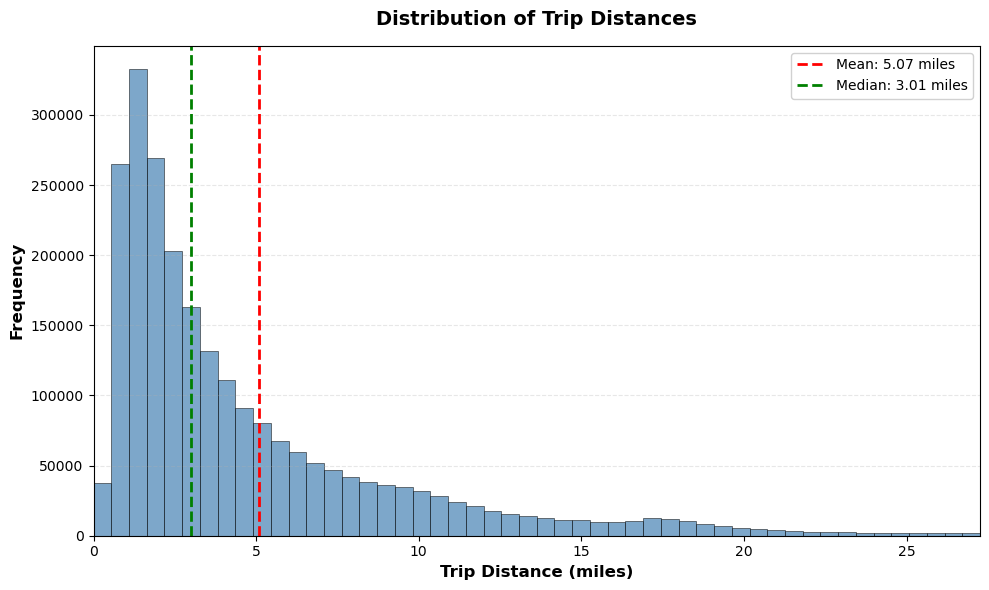

  [OK] Saved: trip_distance_distribution.png


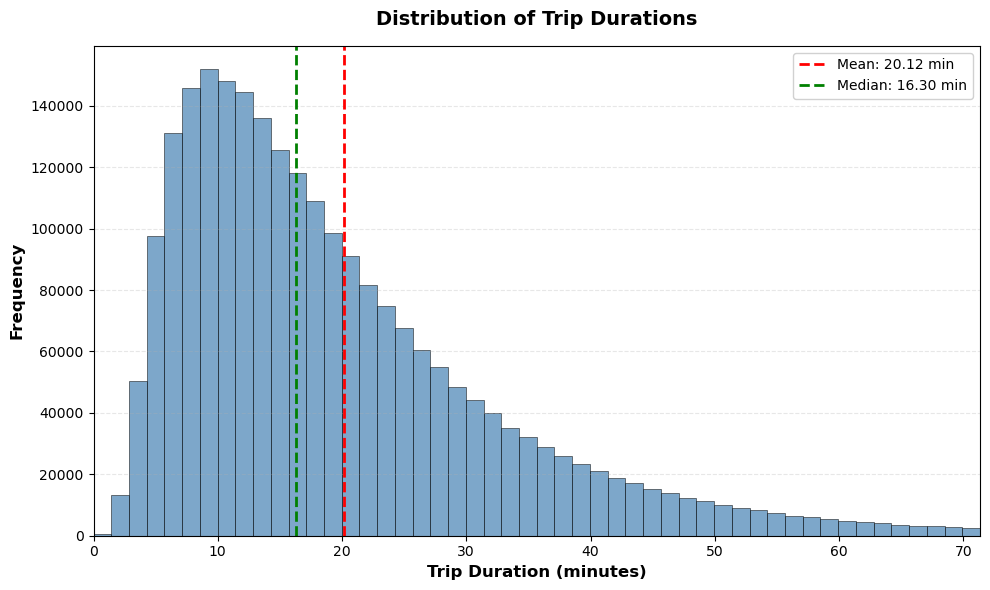

  [OK] Saved: trip_duration_distribution.png


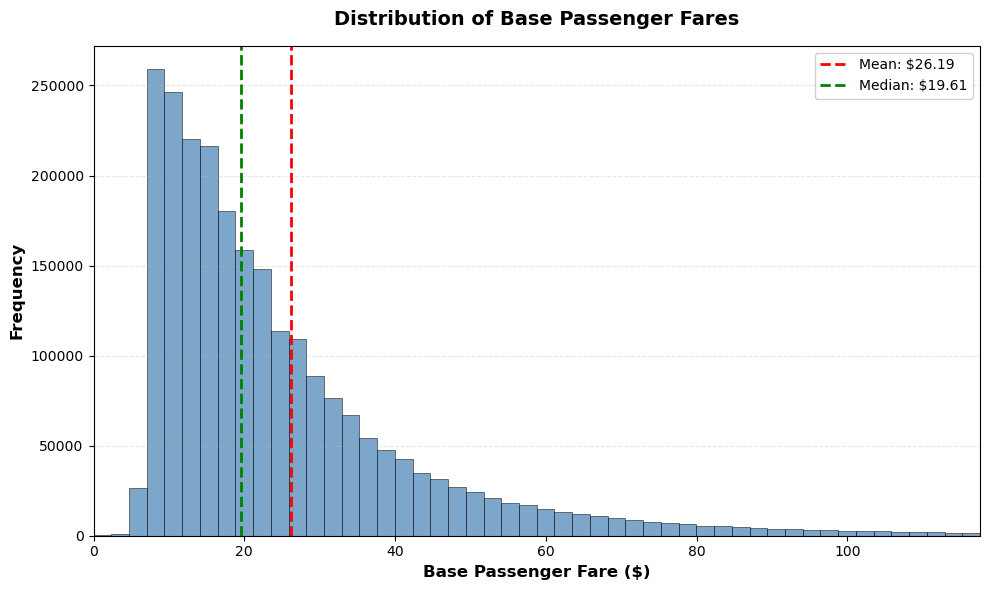

  [OK] Saved: fare_distribution.png

[2/6] Creating temporal analysis...

Creating temporal analysis...


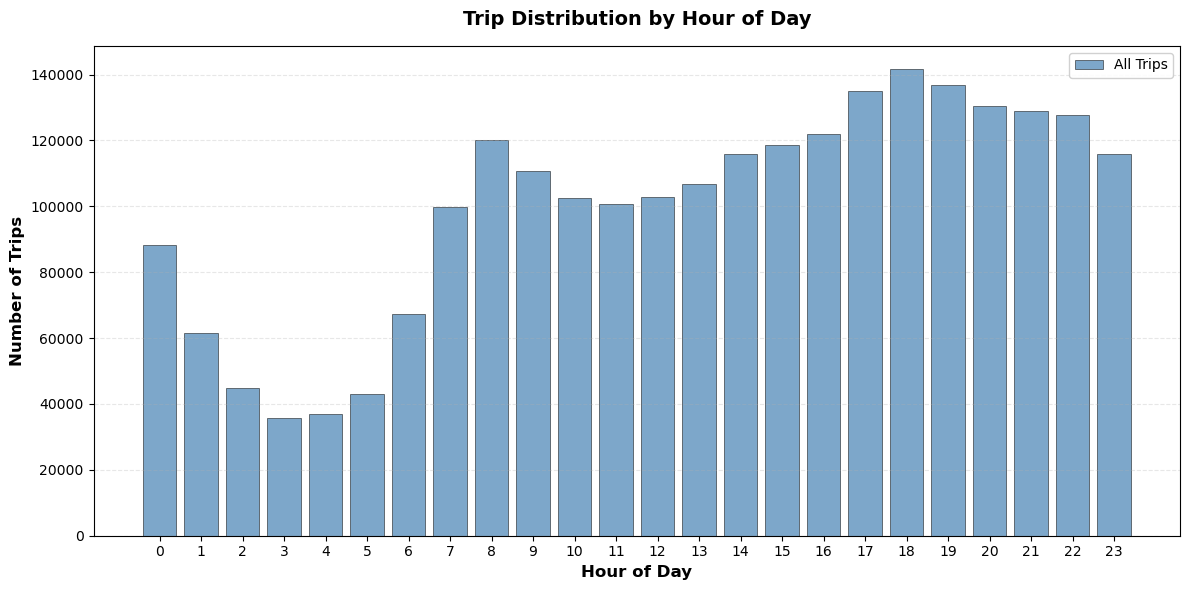

  [OK] Saved: trips_by_hour.png


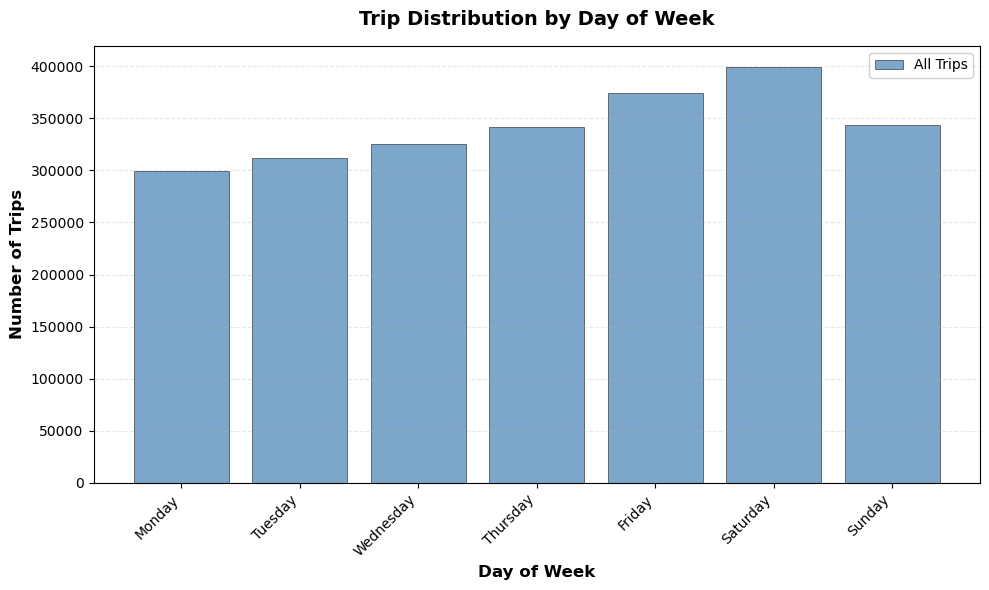

  [OK] Saved: trips_by_day.png

[3/6] Creating location analysis...

Creating location analysis...


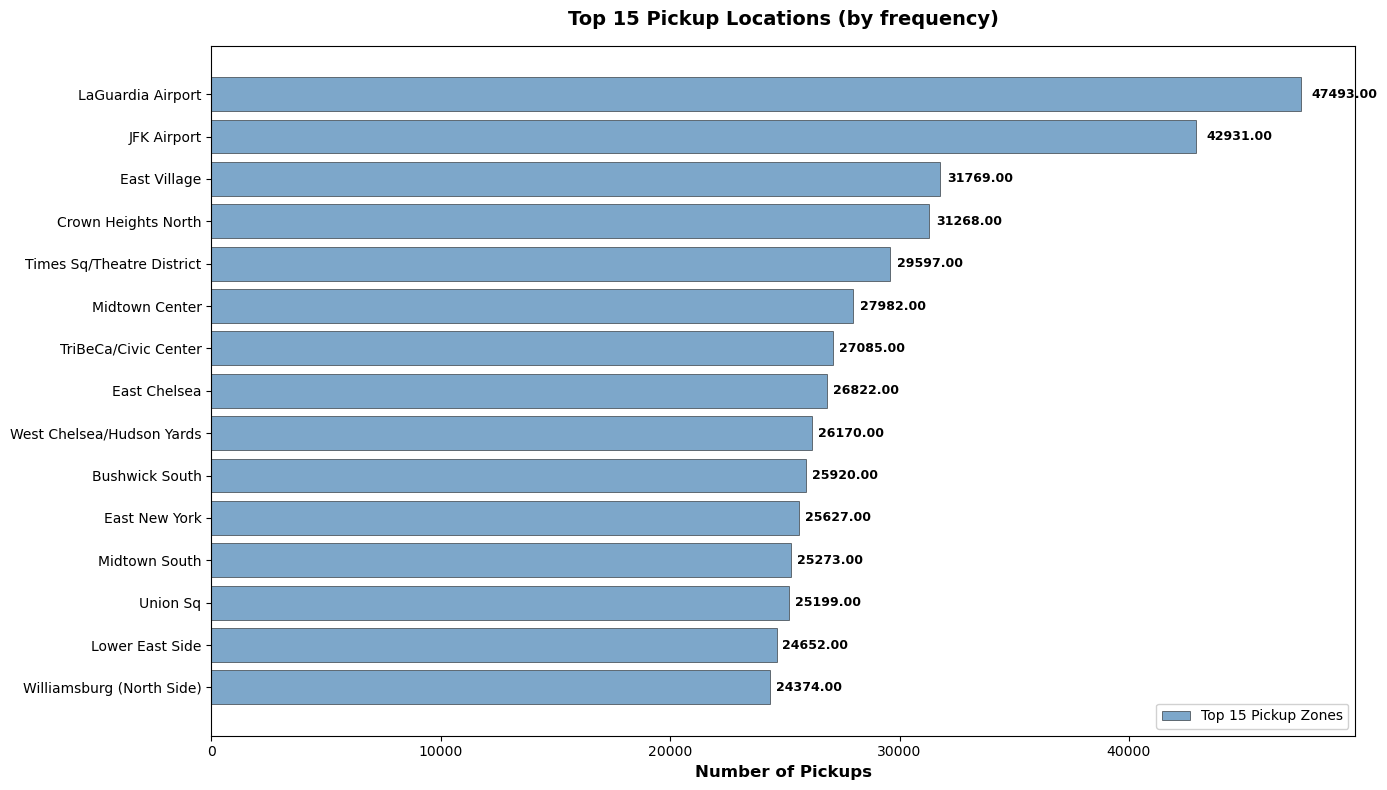

  [OK] Saved: top_pickup_locations.png


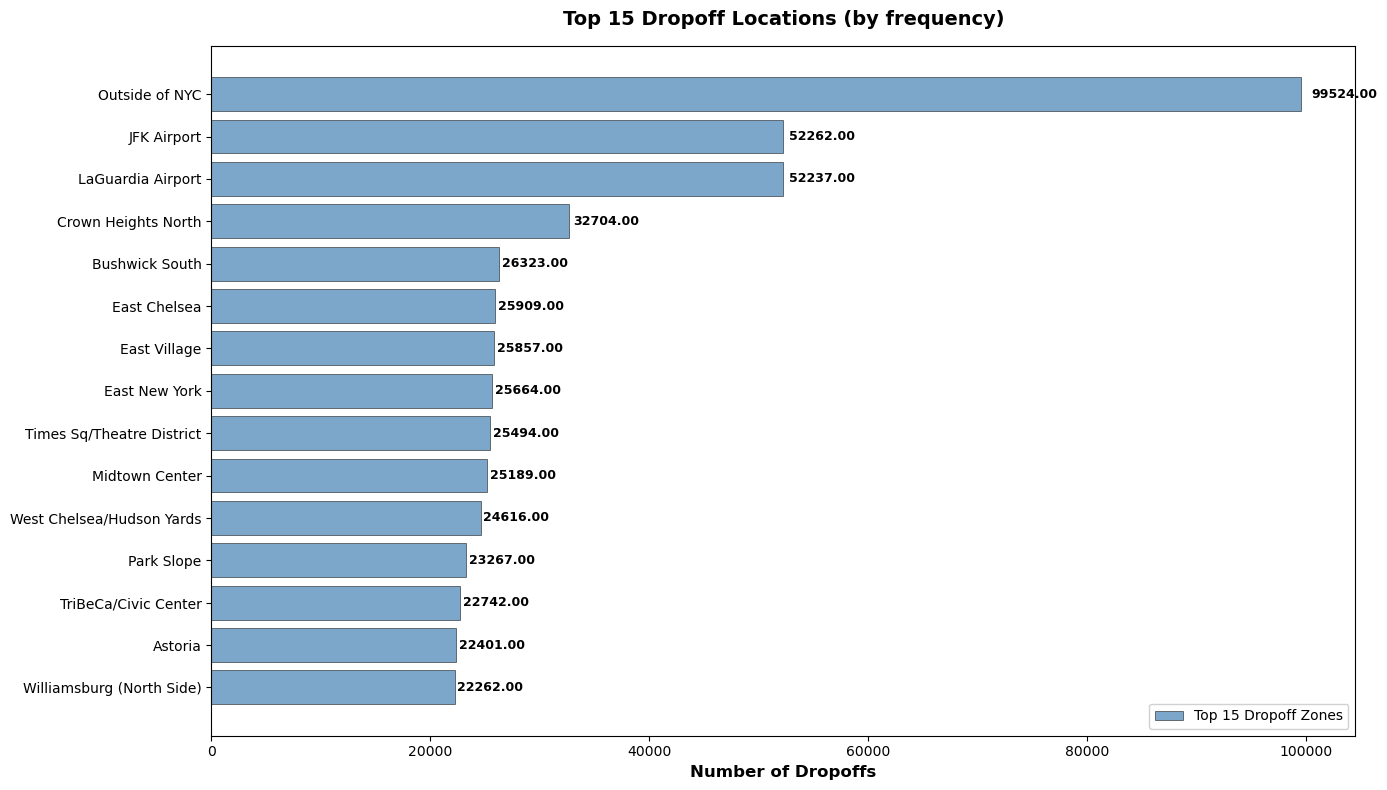

  [OK] Saved: top_dropoff_locations.png

[4/6] Creating demand analysis...

Creating demand analysis outputs...


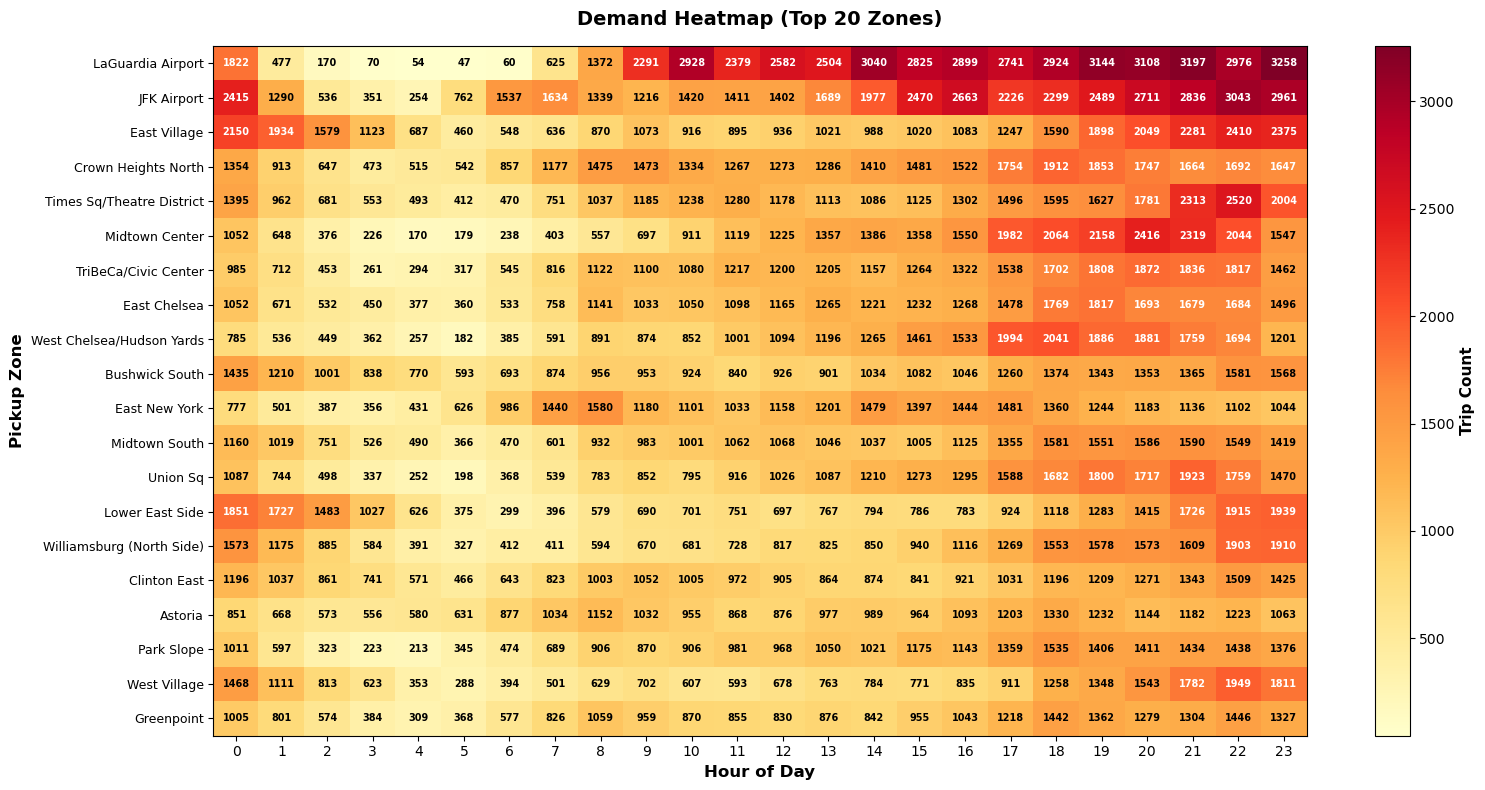

  [OK] Saved: demand_heatmap.png


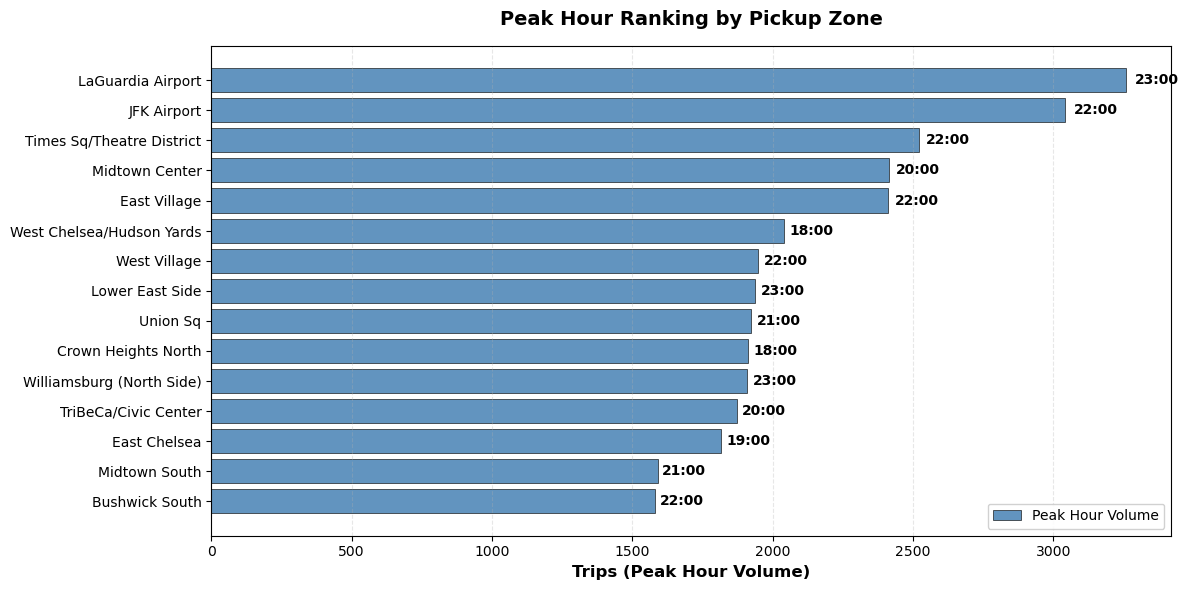

  [OK] Saved: peak_hour_chart.png


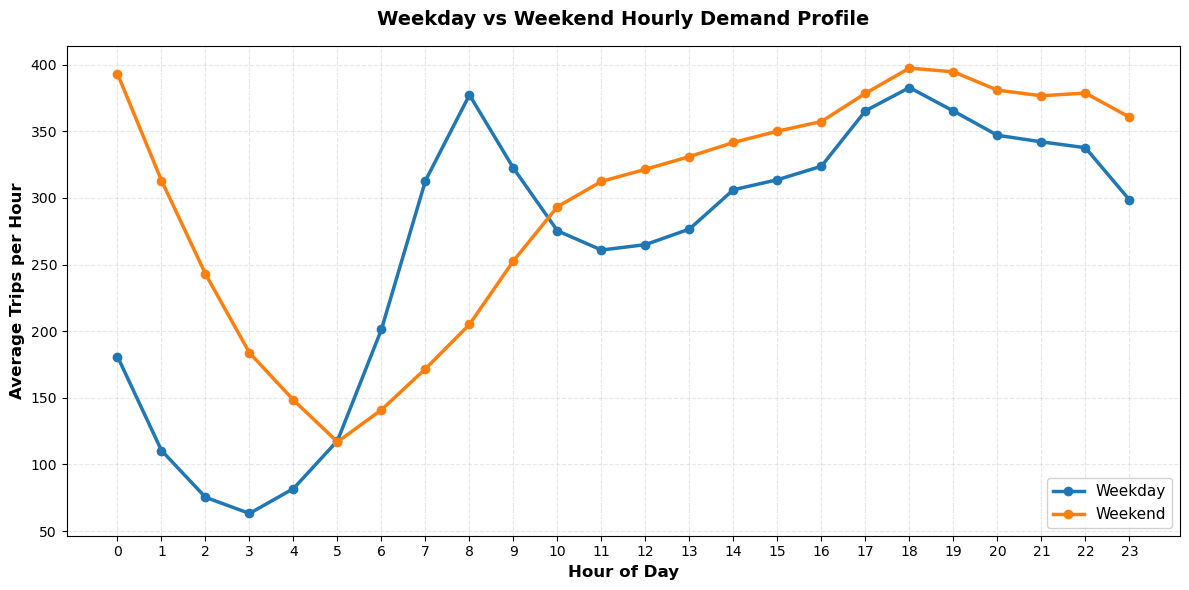

  [OK] Saved: temporal_pattern_plot.png


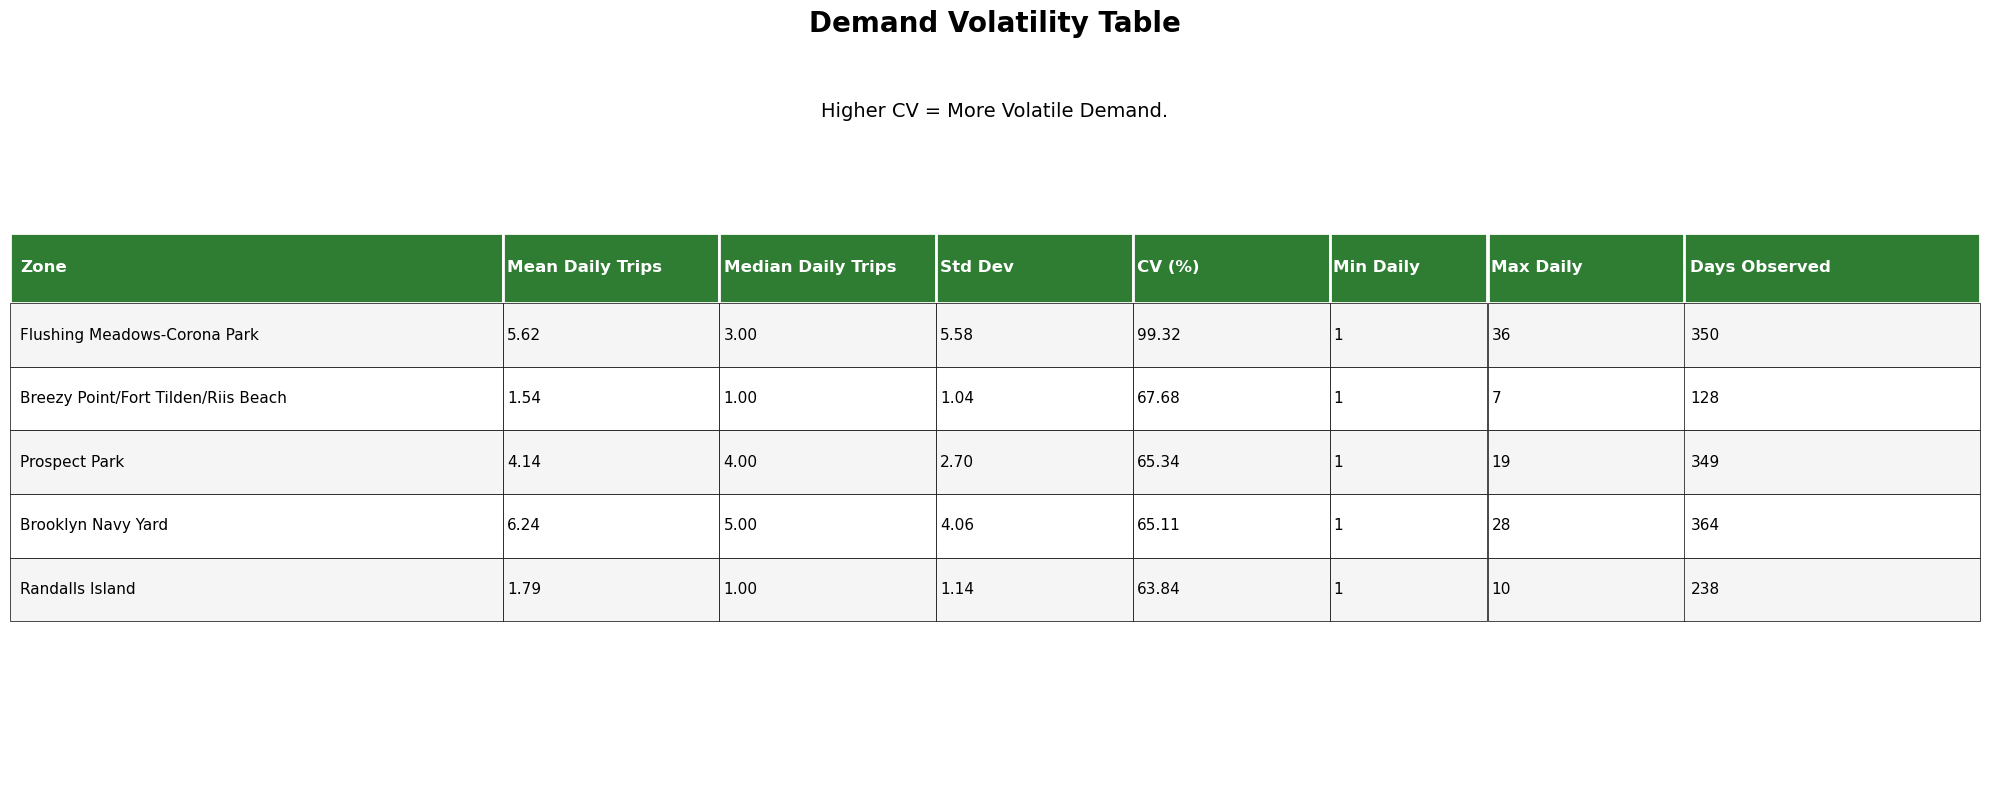

  [OK] Saved: demand_volatility_table.png
  [OK] Saved: demand_volatility_table.csv -> plots\demand_volatility_table.csv

[5/6] Creating NYC interactive map...

Creating interactive NYC demand map...
  [OK] Saved: nyc_hourly_interactive_map.html -> plots\nyc_hourly_interactive_map.html

[6/6] Creating outlier analysis...

Creating outlier analysis...


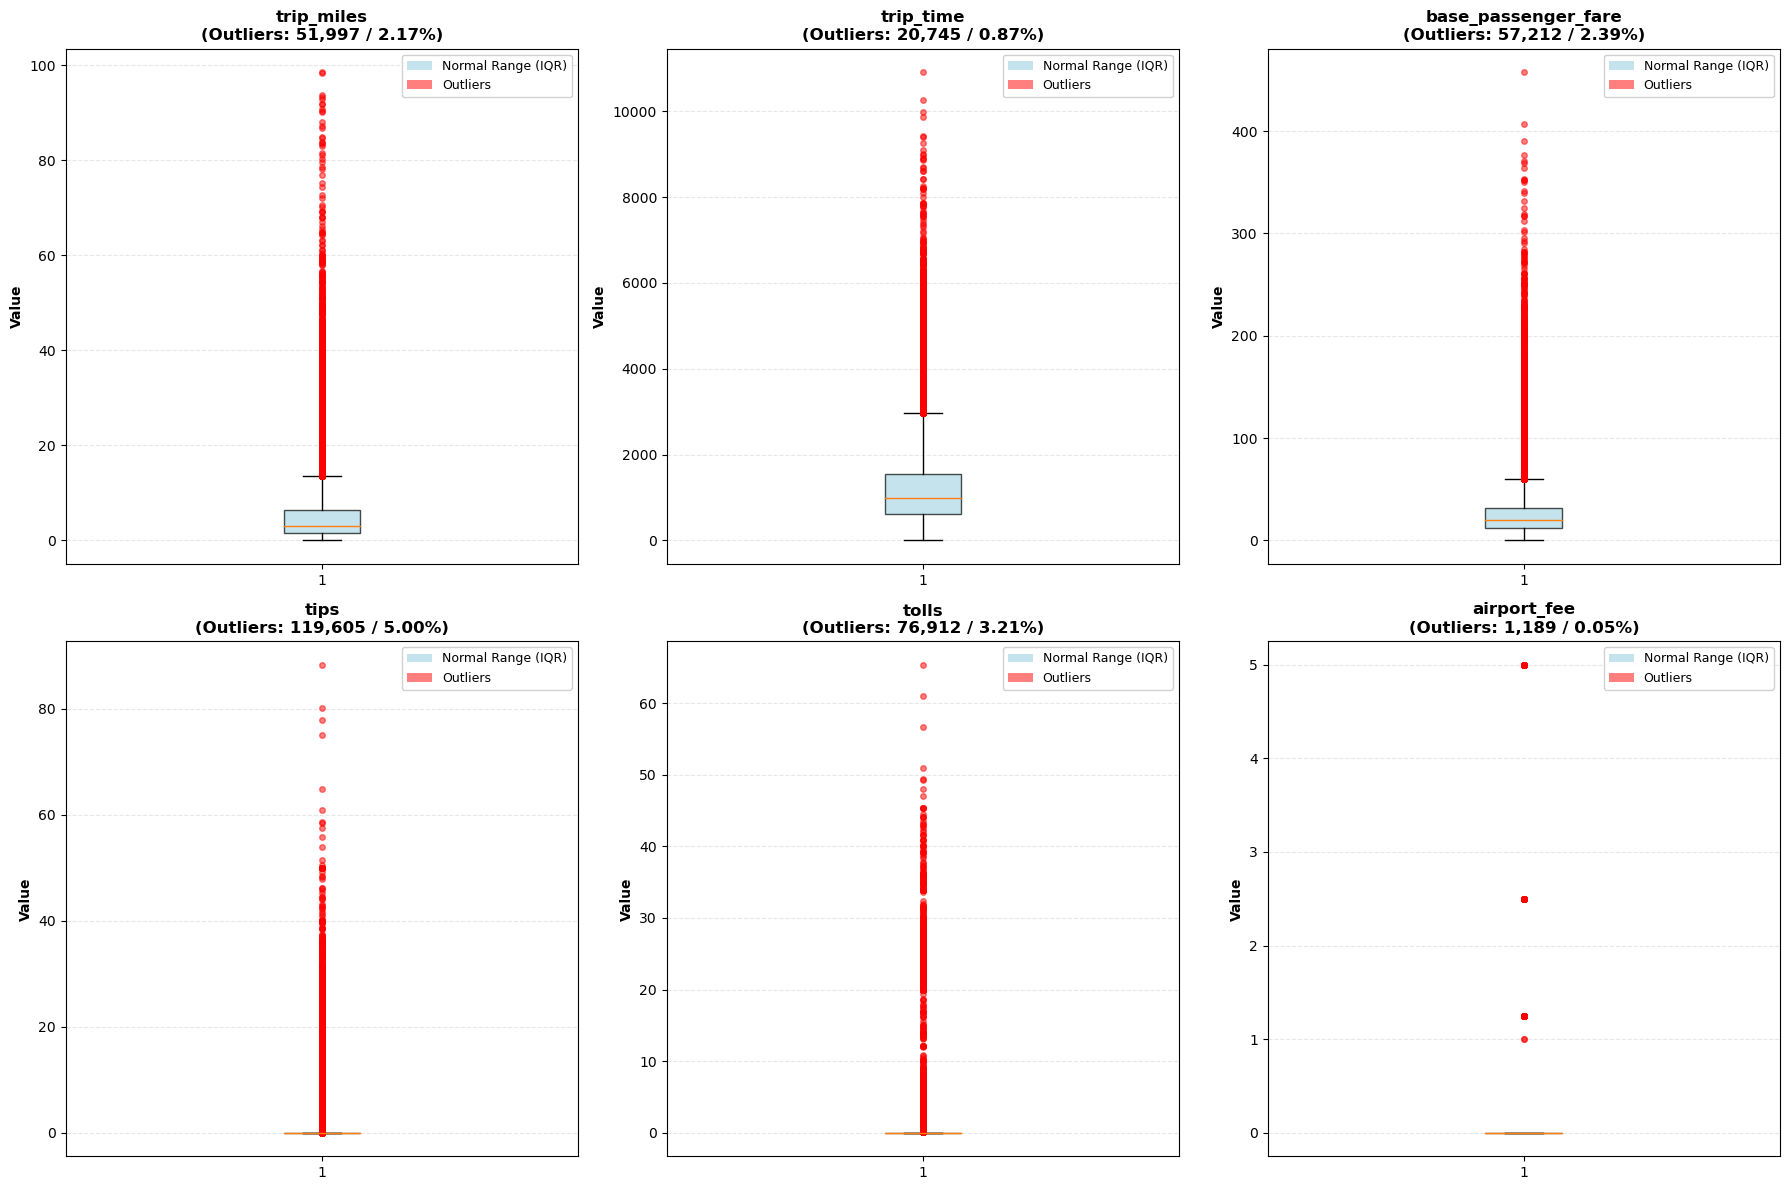

  [OK] Saved: outlier_boxplots.png

Visualization complete!
All charts saved to 'plots/'  directory


In [9]:
if 'df' in locals() and df is not None:
    print("\n" + "="*80)
    print("Generating visualization charts...")
    print("="*80)
    
    print(f"\n[1/6] Creating distribution plots...")
    create_distribution_plots(df)
    
    print(f"\n[2/6] Creating temporal analysis...")
    create_temporal_analysis(df)
    
    print(f"\n[3/6] Creating location analysis...")
    create_location_analysis(df, zone_lookup_dict=zone_lookup_dict)
    
    print(f"\n[4/6] Creating demand analysis...")
    create_demand_analysis(df, zone_lookup_dict=zone_lookup_dict, sample_ratio=SAMPLE_RATIO)
    
    print(f"\n[5/6] Creating NYC interactive map...")
    create_manhattan_interactive_map(df)
    
    print(f"\n[6/6] Creating outlier analysis...")
    create_outlier_analysis(df)
    
    print("\n" + "="*80)
    print("Visualization complete!")
    print("="*80)
    print("All charts saved to 'plots/'  directory")
else:
    print("[ERROR] Please run the previous cell to load data")
